# Lab Three: Option B : Feature Reduction Through Clustering #

* Billy Nayden
* Sean McWhirter
* Andrew Mejia
* Rajesh Salturi

In [1]:
import plotly
plotly.offline.init_notebook_mode()
import pandas as pd
import numpy as np 
import seaborn as sns 
from mpl_toolkits.mplot3d import Axes3D 
import matplotlib.pyplot as plt
import time
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.svm import SVC
from pandas.plotting import boxplot
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import learning_curve
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error, make_scorer, mean_squared_error, mean_squared_error, median_absolute_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.kernel_approximation import Nystroem
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.model_selection import FeatureImportances
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans



print(__doc__)


Using TensorFlow backend.


Automatically created module for IPython interactive environment


##### Regression Analysis Helper Functions

In [2]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Function for Root mean squared error
#https://stackoverflow.com/questions/17197492/root-mean-square-error-in-python

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)


def rmse(y_actual, y_predicted):
    return np.sqrt(mean_squared_error(y_actual, y_predicted))

#Function for Mean Absolute Percentage Error (MAPE) - Untested
#Adapted from - https://stackoverflow.com/questions/42250958/how-to-optimize-mape-code-in-python
def mape(y_actual, y_predicted): 
    mask = y_actual != 0
    return (np.fabs(y_actual - y_predicted)/y_actual)[mask].mean() * 100

#Create scorers for rmse and mape functions
mae_scorer = make_scorer(score_func=mean_absolute_error, greater_is_better=False)
med_scorer = make_scorer(score_func=median_absolute_error, greater_is_better=False)
rmse_scorer = make_scorer(score_func=rmse, greater_is_better=False)
mape_scorer = make_scorer(score_func=mape, greater_is_better=False)
mse_scorer = make_scorer(score_func = mean_squared_error, greater_is_better=False)

#Make scorer array to pass into cross_validate() function for producing mutiple scores for each cv fold.
errorScoring = {'MAE':  mae_scorer, 
                #'RMSE': rmse_scorer,
                #'MAPE': mape_scorer, 
                #'MSE' : mse_scorer,
                'MED' : med_scorer
               } 

def EvaluateRegressionEstimator(regEstimator, X, y, cv):
    
    scores = cross_validate(regEstimator, X, y, scoring=errorScoring, cv=cv, return_train_score=True)

    #cross val score sign-flips the outputs of MAE
    # https://github.com/scikit-learn/scikit-learn/issues/2439
    scores['test_MAE'] = scores['test_MAE'] * -1
    #scores['test_MAPE'] = scores['test_MAPE'] * -1
    #scores['test_RMSE'] = scores['test_RMSE'] * -1
    #scores['test_MSE'] = scores['test_MSE'] * -1
    scores['score_time'] = scores['score_time']
    scores['test_MED'] = scores['test_MED'] * -1
    
    

    #print mean MAE for all folds 
    #maeAvg = scores['test_MAE'].mean()
    #print_str = "The average MAE for all cv folds is: \t\t\t {maeAvg:.5}"
    #print(print_str.format(maeAvg=maeAvg))
    
    #print mean MED for all folds 
    med = np.mean(scores['test_MED'])
    print_str = "The average of the median absolute error for all cv folds is: \t\t\t {med:.5}"
    print(print_str.format(med=med))
    print('*********************************************************')

    #print mean test_MAPE for all folds
    #scores['test_MAPE'] = scores['test_MAPE']
    #mape_avg = scores['test_MAPE'].mean()
    #print_str = "The average MAE percentage (MAPE) for all cv folds is: \t {mape_avg:.5}"
    #print(print_str.format(mape_avg=mape_avg))

    #print mean MAE for all folds 
    #RMSEavg = scores['test_RMSE'].mean()
    #print_str = "The average RMSE for all cv folds is: \t\t\t {RMSEavg:.5}"
    #print(print_str.format(RMSEavg=RMSEavg))
    #print('*********************************************************')
    
    #print mean MAE for all folds 
    #MSEavg = scores['test_MSE'].mean()
    #print_str = "The average MSE for all cv folds is: \t\t\t {MSEavg:.5}"
    #print(print_str.format(MSEavg=MSEavg))
    #print('*********************************************************')
    
    
    Mst = scores['score_time'].mean()
    print_str = "The average score_time for all cv folds is: \t\t\t {Mst:.5}"
    print(print_str.format(Mst=Mst))
    print('*********************************************************')


    print('Cross Validation Fold Mean Error Scores')
    scoresResults = pd.DataFrame()
    #scoresResults['MAE'] = scores['test_MAE']
    scoresResults['MED'] = scores['test_MED']
    #scoresResults['MAPE'] = scores['test_MAPE']
    #scoresResults['RMSE'] = scores['test_RMSE']
    #scoresResults['MSE'] = scores['test_MSE']
    scoresResults['SCORE_TIME'] = scores['score_time']
    
    return scoresResults

#This function will plot PCs based on the length of features in the dataframe or change to how many features you wish to input 
def plot_pca(X,var_ratio_pcs = 60):
    # Perform PCA on the data to reduce the number of initial features 
    # and to remove correlations that are common between pixel features 
    pca = PCA(n_components=X.shape[1])
    pca.fit(X)

    # Inspect the explained variances to determine how many components to use  
    plt.subplots(figsize=(8, 8))
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance');
    print('Cumulative Explained variance explained with :', var_ratio_pcs , 'components:',sum(pca.explained_variance_ratio_[0:var_ratio_pcs]) )

##### Other Helper Functions

In [3]:
def remove_white_space(cols_list, dataframe): 
    df = dataframe
    for col in cols_list:
        df[col] = df[col].str.strip()
    return df 
    
    
def unique_categories(columns_list, dataframe_1): 
    miss_cat_vars = {}
    for var in columns_list: 
        print(var)
        k,v = var,dataframe_1[var].unique()
        miss_cat_vars.update({k : v})
    return miss_cat_vars

#Adapted from Jezreal's answer 
#https://stackoverflow.com/questions/51189962/how-to-replace-0-values-with-mean-based-on-groupby

def grouper_impute(dataframe_2, grouper_col = None, grouper_impute = None, replace_val = None, transfrmtn = None): 

    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].replace(replace_val, np.nan)
    dataframe_2[grouper_impute] = dataframe_2[grouper_impute].fillna(dataframe_2.groupby(grouper_col)[grouper_impute].transform(transfrmtn))
    return dataframe_2


# This function creates dummy encodings from a lsit of features of interest and returns a dataframe     
def create_dummy_encod(ml_df,features_of_interest, drop_first_cat=True, sparsity=True): 
    tmp_cont = []
    ml_data_copy = ml_df.copy()
    for feat in features_of_interest: 
        tmp_df = pd.get_dummies(ml_data_copy[feat],prefix=str(feat),sparse=sparsity,drop_first=drop_first_cat)
        tmp_cont.append(tmp_df)
        feat_df = pd.concat(tmp_cont,axis=1)
        ml_df = pd.concat([ml_data_copy,feat_df], axis=1)
        ml_df = ml_df.drop(columns = features_of_interest, axis = 1)
    return ml_df 


# Data Understanding 1

>Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems? # 

The data set we will be working with is the NYC property data sales from New York City for the 5 boroughs.

https://www.kaggle.com/new-york-city/nyc-property-sales

We want to create a regressor to predict a property's SALE PRICE, for the entire dynamic range of values from the data set. Recall the dynamic range is from 1e0 to 2.2e9. 

This dataset contains the location, address, type, sale price, and sale date of building units sold. A reference on the trickier fields:

BOROUGH: A digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

BLOCK; LOT: The combination of borough, block, and lot forms a unique key for property in New York City. Commonly called a BBL. We will not use this combination in our analysis, as we will treat Block and Lot as independent features, since it is a nominal label created using this type of key value pair. Rather, we will engineer a feature using BOROUGH and ZIPCODE to proxy a similar result for our clustering analysis. 
https://www.health.ny.gov/statistics/cancer/registry/appendix/neighborhoods.htm


BUILDING CLASS AT PRESENT and BUILDING CLASS AT TIME OF SALE: The type of building at various points in time. See the glossary linked to below.

Note that because this is a financial transaction dataset, there are some points that need to be kept in mind:

There are sales with a $0 dollar value. These sales are actually transfers of deeds between parties: for example, parents transferring ownership of their home to a child after moving out for retirement. There are also dollar values of '-', which we are not sure what these are, as there is no clear definition in the documentation. 

For the later part of the experiment. 

# Reading in and previewing the data 

In [4]:
raw_data_url = 'https://raw.githubusercontent.com/andrewmejia600/MSDS7331/master/RAW_DATA/nyc-rolling-sales.csv'
#raw_data_url = '/media/andrew/29426984-e707-487c-8f66-ca5e368b23d12/Documents/School/HomeWork/ML_1/TEAM_GH/MSDS7331/RAW_DATA/nyc-rolling-sales.csv'

In [5]:
raw_data = pd.read_csv(raw_data_url, encoding="utf-8", converters = {'LAND SQUARE FEET': str.strip, 'GROSS SQUARE FEET' : str.strip, 'SALE PRICE': str.strip  } )
raw_data.head(n=5)

Unnamed: 0  BOROUGH   NEIGHBORHOOD  \
0           4        1  ALPHABET CITY   
1           5        1  ALPHABET CITY   
2           6        1  ALPHABET CITY   
3           7        1  ALPHABET CITY   
4           8        1  ALPHABET CITY   

                       BUILDING CLASS CATEGORY TAX CLASS AT PRESENT  BLOCK  \
0  07 RENTALS - WALKUP APARTMENTS                                2A    392   
1  07 RENTALS - WALKUP APARTMENTS                                 2    399   
2  07 RENTALS - WALKUP APARTMENTS                                 2    399   
3  07 RENTALS - WALKUP APARTMENTS                                2B    402   
4  07 RENTALS - WALKUP APARTMENTS                                2A    404   

   LOT EASE-MENT BUILDING CLASS AT PRESENT                 ADDRESS  ...  \
0    6                                  C2            153 AVENUE B  ...   
1   26                                  C7   234 EAST 4TH   STREET  ...   
2   39                                  C7   197 EAST 3RD   STREET  ...   
3   21                                  C4     154 EAST 7TH STREET  ...   
4   55                                  C2  301 EAST 10TH   STREET  ...   

  RESIDENTIAL UNITS  COMMERCIAL UNITS  TOTAL UNITS  LAND SQUARE FEET  \
0                 5                 0            5              1633   
1                28                 3           31              4616   
2                16                 1           17              2212   
3                10                 0           10              2272   
4                 6                 0            6              2369   

   GROSS SQUARE FEET YEAR BUILT TAX CLASS AT TIME OF SALE  \
0               6440       1900                         2   
1              18690       1900                         2   
2               7803       1900                         2   
3               6794       1913                         2   
4               4615       1900                         2   

   BUILDING CLASS AT TIME OF SALE  SALE PRICE            SALE DATE  
0                              C2     6625000  2017-07-19 00:00:00  
1                              C7           -  2016-12-14 00:00:00  
2                              C7           -  2016-12-09 00:00:00  
3                              C4     3936272  2016-09-23 00:00:00  
4                              C2     8000000  2016-11-17 00:00:00  

[5 rows x 22 columns]

In [6]:
raw_data.columns

Index(['Unnamed: 0', 'BOROUGH', 'NEIGHBORHOOD', 'BUILDING CLASS CATEGORY',
       'TAX CLASS AT PRESENT', 'BLOCK', 'LOT', 'EASE-MENT',
       'BUILDING CLASS AT PRESENT', 'ADDRESS', 'APARTMENT NUMBER', 'ZIP CODE',
       'RESIDENTIAL UNITS', 'COMMERCIAL UNITS', 'TOTAL UNITS',
       'LAND SQUARE FEET', 'GROSS SQUARE FEET', 'YEAR BUILT',
       'TAX CLASS AT TIME OF SALE', 'BUILDING CLASS AT TIME OF SALE',
       'SALE PRICE', 'SALE DATE'],
      dtype='object')

# Data Meaning

The raw data attribute explanations are as follows:

Unnamed: 0 - An index from the data source that is not defined

BOROUGH - A nominal digit code for the borough the property is located in; in order these are Manhattan (1), Bronx (2), Brooklyn (3), Queens (4), and Staten Island (5).

NEIGHBOHOOD - The neighboorhood of the address, a nominal value

BUILDING CLASS CATEGORY - Is the description of the building class, reference, a nominal value 
https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html

TAX CLASS AT PRESENT - The Tax class of the building at the time when the data was collected, a nominal value

BLOCK - The physical block of the address, a nominal value 

LOT - The lot on the the block, a nominal value 

EASE-MENT - A sparse column with no values in it, just white space.

BUILDING CLASS AT PRESENT - The building class at the time of data collection, a nominal value 

ADDRESS - The Physical address of the building, a nominal value 

APARTMENT NUMBER - The Apartment Number of the unit, a nominal value 

ZIP CODE - Zip Code of the property, a nominal value

RESIDENTIAL UNITS - The number of residential units to the building, an integer value 

COMMERCIAL UNITS - The number of commerifal units to the building, an integer value 

TOTAL UNITS - The number of total units, the sum of Residential and Commercial Units to the building, an integer value 

LAND SQUARE FEET - The physical foot print of square feet of the building, an integer value 

GROSS SQUARE FEET - The entire square footage of the buidling, the sum of the floor square footage for mutli-story buildings, an integer value 

YEAR BUILT - The year of construction of the property, an ordinal value 

TAX CLASS AT TIME OF SALE - The tax class of the building when the property sold, a nominal value 

BUILDING CLASS AT TIME OF SALE - The building class at the time when the property sold, a nominal value 

SALE PRICE - The sale price of the building, $0 are indicative of family property transfers and '-' are where there is no known sale price, an integer value 

SALE DATE - The sale date of the property, an ordinal value

In [7]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 22 columns):
Unnamed: 0                        84548 non-null int64
BOROUGH                           84548 non-null int64
NEIGHBORHOOD                      84548 non-null object
BUILDING CLASS CATEGORY           84548 non-null object
TAX CLASS AT PRESENT              84548 non-null object
BLOCK                             84548 non-null int64
LOT                               84548 non-null int64
EASE-MENT                         84548 non-null object
BUILDING CLASS AT PRESENT         84548 non-null object
ADDRESS                           84548 non-null object
APARTMENT NUMBER                  84548 non-null object
ZIP CODE                          84548 non-null int64
RESIDENTIAL UNITS                 84548 non-null int64
COMMERCIAL UNITS                  84548 non-null int64
TOTAL UNITS                       84548 non-null int64
LAND SQUARE FEET                  84548 non-null object
GRO

In [8]:
housing_data = raw_data.copy()

We see there are potentially 22 features for us to use for the regression task of the data. We will drop the **Unamed 0:** column as it appears to be an index that is not of importance. 

**EASE-MENT** is another feature that is mostly sparse, and shows no real value as a feature. 

Address has many nominal values and will not serve as a sound predictor, and will drastically increase the number of features to be encoded, so we will drop this column as well.  

Therefore the further analysis and model testing will be conducted without Unamed:0, EASE-MENT, and Address. We will also replace **SALE DATE** with **DATEOFSALE** as **DATEOFSALE** will be used for downline processing and will be in date time format. 

In [9]:
housing_data['DATEOFSALE'] = pd.to_datetime(housing_data['SALE DATE'])

In [10]:
housing_data = housing_data.drop(columns = ['Unnamed: 0', 'EASE-MENT', 'APARTMENT NUMBER', 'SALE DATE'], axis = 1)

# Data Quality 

We are removing the whitespace from the column names to make them easier to manipulate in our modeling analysis and building.

In [11]:
housing_data.columns = housing_data.columns.str.replace(' ', '')

We are removing the whitespace from the column values to make them easier to manipulate in our modeling analysis and building.

In [12]:
catagorical_vars = list(housing_data.select_dtypes(include='object').columns)
print(catagorical_vars)

['NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'ADDRESS', 'LANDSQUAREFEET', 'GROSSSQUAREFEET', 'BUILDINGCLASSATTIMEOFSALE', 'SALEPRICE']


In [13]:
housing_data = remove_white_space(catagorical_vars, housing_data)

We take a copy of the housing_data since we will be imputing the $0 dollar values based on the zip code median for further clustering analysis 

In [14]:
housing_data_imputed = housing_data.copy() 

In [15]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 19 columns):
BOROUGH                      84548 non-null int64
NEIGHBORHOOD                 84548 non-null object
BUILDINGCLASSCATEGORY        84548 non-null object
TAXCLASSATPRESENT            84548 non-null object
BLOCK                        84548 non-null int64
LOT                          84548 non-null int64
BUILDINGCLASSATPRESENT       84548 non-null object
ADDRESS                      84548 non-null object
ZIPCODE                      84548 non-null int64
RESIDENTIALUNITS             84548 non-null int64
COMMERCIALUNITS              84548 non-null int64
TOTALUNITS                   84548 non-null int64
LANDSQUAREFEET               84548 non-null object
GROSSSQUAREFEET              84548 non-null object
YEARBUILT                    84548 non-null int64
TAXCLASSATTIMEOFSALE         84548 non-null int64
BUILDINGCLASSATTIMEOFSALE    84548 non-null object
SALEPRICE                    8454

In [16]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 84548 entries, 0 to 84547
Data columns (total 19 columns):
BOROUGH                      84548 non-null int64
NEIGHBORHOOD                 84548 non-null object
BUILDINGCLASSCATEGORY        84548 non-null object
TAXCLASSATPRESENT            84548 non-null object
BLOCK                        84548 non-null int64
LOT                          84548 non-null int64
BUILDINGCLASSATPRESENT       84548 non-null object
ADDRESS                      84548 non-null object
ZIPCODE                      84548 non-null int64
RESIDENTIALUNITS             84548 non-null int64
COMMERCIALUNITS              84548 non-null int64
TOTALUNITS                   84548 non-null int64
LANDSQUAREFEET               84548 non-null object
GROSSSQUAREFEET              84548 non-null object
YEARBUILT                    84548 non-null int64
TAXCLASSATTIMEOFSALE         84548 non-null int64
BUILDINGCLASSATTIMEOFSALE    84548 non-null object
SALEPRICE                    8454

As we are not sure what the '-' value for sale price means, we will omit it from further analysis, as these could be family property transfers or transfers other than sales where there is not a $0 value or there is no other data known for this observation. We see there are 14561 observations of this type. It must be stated, for future generalizations, the outcomes of these regression models for both the housing_data and housing_data_imputed are limited to observations that do not fall into this category. 

In [17]:
len(housing_data[housing_data['SALEPRICE'] == '-']) 

14561

We see this is also the case with **LANDSQUAREFEET** and **GROSSSQUAREFEET** as well and we see there are instances where there is a 0 **Zipcode**. As there is no way to vet what the true zip code of the property would be, without extensive searching, we will exclude these observations from our initial analysis, but we will impute the zero values with the zipcode medians in the imputed dataframe, **housing_data_imputed**, only. We also see there are some properties with a 0 total units, so we will exclude these observations from our initial clustering data set, housing_data, as we do not want to artifically inflate the number of total units by adding to the column. With these exclusions, we must restate our previous disclaimer of the outcomes of these regression models are limited to observations that do not fall into this category.

In [18]:
len(housing_data[((housing_data['LANDSQUAREFEET'] == '-') | (housing_data['GROSSSQUAREFEET'] == '-') | (housing_data['SALEPRICE'] == '-'))])

36304

In [19]:
housing_data = housing_data[~((housing_data['LANDSQUAREFEET'] == '-') | (housing_data['GROSSSQUAREFEET'] == '-') | (housing_data['SALEPRICE'] == '-'))]

housing_data_imputed = housing_data_imputed[~((housing_data_imputed['LANDSQUAREFEET'] == '-') | (housing_data_imputed['GROSSSQUAREFEET'] == '-') | (housing_data_imputed['SALEPRICE'] == '-'))]

In [20]:
housing_data = housing_data[(housing_data['ZIPCODE'] != 0) & (housing_data['TOTALUNITS'] != 0)
                           & (housing_data['SALEPRICE'] != 0) & (housing_data['YEARBUILT'] != 0)
                           & (housing_data['LANDSQUAREFEET'] != 0) & (housing_data['GROSSSQUAREFEET'] != 0)] 

Resetting the index to the data

In [21]:
housing_data = housing_data.reset_index(drop=True)

In [22]:
housing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41411 entries, 0 to 41410
Data columns (total 19 columns):
BOROUGH                      41411 non-null int64
NEIGHBORHOOD                 41411 non-null object
BUILDINGCLASSCATEGORY        41411 non-null object
TAXCLASSATPRESENT            41411 non-null object
BLOCK                        41411 non-null int64
LOT                          41411 non-null int64
BUILDINGCLASSATPRESENT       41411 non-null object
ADDRESS                      41411 non-null object
ZIPCODE                      41411 non-null int64
RESIDENTIALUNITS             41411 non-null int64
COMMERCIALUNITS              41411 non-null int64
TOTALUNITS                   41411 non-null int64
LANDSQUAREFEET               41411 non-null object
GROSSSQUAREFEET              41411 non-null object
YEARBUILT                    41411 non-null int64
TAXCLASSATTIMEOFSALE         41411 non-null int64
BUILDINGCLASSATTIMEOFSALE    41411 non-null object
SALEPRICE                    4141

In [23]:
housing_data_imputed = housing_data_imputed.reset_index(drop=True)

In [24]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48244 entries, 0 to 48243
Data columns (total 19 columns):
BOROUGH                      48244 non-null int64
NEIGHBORHOOD                 48244 non-null object
BUILDINGCLASSCATEGORY        48244 non-null object
TAXCLASSATPRESENT            48244 non-null object
BLOCK                        48244 non-null int64
LOT                          48244 non-null int64
BUILDINGCLASSATPRESENT       48244 non-null object
ADDRESS                      48244 non-null object
ZIPCODE                      48244 non-null int64
RESIDENTIALUNITS             48244 non-null int64
COMMERCIALUNITS              48244 non-null int64
TOTALUNITS                   48244 non-null int64
LANDSQUAREFEET               48244 non-null object
GROSSSQUAREFEET              48244 non-null object
YEARBUILT                    48244 non-null int64
TAXCLASSATTIMEOFSALE         48244 non-null int64
BUILDINGCLASSATTIMEOFSALE    48244 non-null object
SALEPRICE                    4824

We wanted to create a copy of the sale price for use with our imputations for the regression of sale price and to perserve the original sale price as we will be performing group imputations based on the median zipcode later in the notebook. 

In [25]:
housing_data_imputed['SALEPRICECPY'] = housing_data_imputed['SALEPRICE']


We see some attributes, such as **LANDSQUREFEET**, **GROSSSUAREFEET** and **SALEPRICE** are the wrong data type. 
We are changing the data types to **SALEPRICE**, **LANDSQUAREFEET** and **GROSSSQUAREFEET** to int64, and making **ZIPCODE** a nominal label, as **ZIPCODE** is more of a nominal label in this case rather than an ordinal value, since a higher **ZIPCODE** number does not necessiarily correspond to a more favorable property.

In [26]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
housing_data = housing_data.astype({'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object'})

housing_data_imputed = housing_data_imputed.astype({'SALEPRICE': 'int64', 'SALEPRICECPY': 'int64', 'LANDSQUAREFEET' : 'int64', 'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object'})

We shall impute the $0 **SALEPRICE** feature, that are family transfers, with the median saleprice of the **ZIPCODE**. As we are assuming these values should be relatively close to each other if they are within the zip code, since using **BOROUGH** could be too general. 

We will impute **YEARBUILT**, **LANDSQUAREFEET** and **GROSSSQUREFEET** with the median of the **ZIPCODE** as well for similar reasons. 

This is only for the imputed dataframe, **housing_data_imputed** only


In [27]:
housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'SALEPRICE', replace_val = 0, transfrmtn = 'median')

housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'YEARBUILT', replace_val = 0, transfrmtn = 'median')


housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'LANDSQUAREFEET', replace_val = 0, transfrmtn = 'median')

housing_data_imputed = grouper_impute(dataframe_2 = housing_data_imputed, grouper_col = 'ZIPCODE', grouper_impute = 'GROSSSQUAREFEET', replace_val = 0, transfrmtn = 'median')

In [28]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48244 entries, 0 to 48243
Data columns (total 20 columns):
BOROUGH                      48244 non-null int64
NEIGHBORHOOD                 48244 non-null object
BUILDINGCLASSCATEGORY        48244 non-null object
TAXCLASSATPRESENT            48244 non-null object
BLOCK                        48244 non-null int64
LOT                          48244 non-null int64
BUILDINGCLASSATPRESENT       48244 non-null object
ADDRESS                      48244 non-null object
ZIPCODE                      48244 non-null object
RESIDENTIALUNITS             48244 non-null int64
COMMERCIALUNITS              48244 non-null int64
TOTALUNITS                   48244 non-null int64
LANDSQUAREFEET               48244 non-null float64
GROSSSQUAREFEET              48244 non-null float64
YEARBUILT                    48244 non-null float64
TAXCLASSATTIMEOFSALE         48244 non-null int64
BUILDINGCLASSATTIMEOFSALE    48244 non-null object
SALEPRICE                   

In [29]:
housing_data_imputed.describe()

BOROUGH         BLOCK           LOT  RESIDENTIALUNITS  \
count  48244.000000  48244.000000  48244.000000      48244.000000   
mean       3.251741   4984.532191    234.324662          2.566537   
std        0.903136   3427.418090    496.361521         17.465481   
min        1.000000      1.000000      1.000000          0.000000   
25%        3.000000   2206.750000     21.000000          1.000000   
50%        3.000000   4660.500000     45.000000          1.000000   
75%        4.000000   6996.000000     94.000000          2.000000   
max        5.000000  16319.000000   9009.000000       1844.000000   

       COMMERCIALUNITS    TOTALUNITS  LANDSQUAREFEET  GROSSSQUAREFEET  \
count     48244.000000  48244.000000    4.824400e+04     4.824400e+04   
mean          0.249171      2.834632    3.864491e+03     4.365970e+03   
std          10.988072     20.750418    3.139752e+04     2.941921e+04   
min           0.000000      0.000000    2.000000e+00     6.000000e+01   
25%           0.000000      1.000000    2.000000e+03     1.590000e+03   
50%           0.000000      1.000000    2.458000e+03     2.208000e+03   
75%           0.000000      2.000000    3.145000e+03     3.000000e+03   
max        2261.000000   2261.000000    4.228300e+06     3.750565e+06   

          YEARBUILT  TAXCLASSATTIMEOFSALE     SALEPRICE  SALEPRICECPY  
count  48244.000000          48244.000000  4.824400e+04  4.824400e+04  
mean    1944.944086              1.475769  1.309274e+06  1.153281e+06  
std       33.733054              0.833589  1.339195e+07  1.340131e+07  
min     1800.000000              1.000000  1.000000e+00  0.000000e+00  
25%     1920.000000              1.000000  4.250000e+05  8.042000e+04  
50%     1931.000000              1.000000  6.225000e+05  4.800000e+05  
75%     1963.000000              2.000000  9.550000e+05  8.300000e+05  
max     2017.000000              4.000000  2.210000e+09  2.210000e+09

#### ENGINEERED FEATURES

We are creating an ordinal feature for when in the month the property sold, 1 being the first of the month, 2 being the middle of the month and 3 being the last of the month. 

In [30]:
string_of_day = housing_data.DATEOFSALE.astype(str).str.slice(start=-2).astype(int)

housing_data['TIMEOFMONTH'] = pd.cut(string_of_day, [1,14,15,31], labels=[1,2,3], include_lowest=True)
housing_data_imputed['TIMEOFMONTH'] = pd.cut(string_of_day, [1,14,15,31], labels=[1,2,3], include_lowest=True)

In [31]:
housing_data.TIMEOFMONTH = housing_data.TIMEOFMONTH.astype(object)

housing_data_imputed.TIMEOFMONTH = housing_data.TIMEOFMONTH.astype(object)

When reviewing https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html the New York Building class at present feature has many nominal features. We wanted a more general feature of what the building type is, i.e. whether the property is a multi family dwelling with vs  with out an elevator. 

* `DWELLING` -- Dwelling
* `MULTI_DWELLING_NO_ELV`-- Multifamily dwelling no elevator 
* `MULTI_DWELLING_ELV` -- Multifamily dwelling with elevator
* `WAREHOUSE` -- Warehouse
* `FACTORY` -- Factory
* `GARAGE_P_LOT` -- Garage or Parking Lot
* `HOTEL` -- Hotel 
* `HOSIPTAL` -- Hospital 
* `THEATRE` -- Theatre
* `RETAIL` -- Retail 
* `LOFT` -- Loft 
* `RELIGIOUS` -- Religious 
* `SOCIAL_INSTITUTION` -- Social Institution, i.e. an Asylum 
* `OFFICE` -- Office 
* `COMMUNITY_CENTER` -- Community Center
* `PUBLIC_REC` -- Public Recreation
* `COMMERCIAL` -- Commercial 
* `DWELLING_RETAIL` -- Dwelling with retail 
* `PORT` -- Port of entry 
* `UTILITY` -- Utility, i.e. railroad 
* `ZONED` -- Zoned, i.e. Courthouse
* `SCHOOL` -- Schools 
* `PUBLIC_SAFETY` -- Public Safety, i.e. Firehouse 
* `OTHER` -- Catch all

In [32]:
#https://www1.nyc.gov/assets/finance/jump/hlpbldgcode.html#A
BUILD_CLASS_DICT_ = {'A' : 'DWELLING', 'B' : 'DWELLING', 'C' : 'MULTI_DWELLING_NO_ELV', 'D' : 'MULTI_DWELLING_ELV', 'E' : 'WAREHOUSE', 'F' : 'FACTORY', 'G' : 'GARAGE_P_LOT', 'H' : 'HOTEL', 'I' : 'HOSIPTAL', 'J' : 'THEATRE', 'K' : 'REATAIL', 'L' : 'LOFT', 'M' : 'RELIGIOUS', 'N' : 'SOCIAL_INSTITUTION', 'O' : 'OFFICE', 'P' : 'COMMUNITY_CENTER', 'Q' : 'PUBLIC_REC', 'R' : 'COMMERCIAL' , 'S' : 'DWELLING_RETAIL', 'T' : 'PORT', 'U' : 'UTILITY', 'V' : 'ZONED', 'W' : 'SCHOOL', 'Y' : 'PUBLIC_SAFETY', 'Z' : 'OTHER'}

housing_data['BUILDCLASSGENER'] = housing_data.BUILDINGCLASSATPRESENT.astype(str).str.slice(start=0, stop=1).map(BUILD_CLASS_DICT_)

housing_data_imputed['BUILDCLASSGENER'] = housing_data_imputed.BUILDINGCLASSATPRESENT.astype(str).str.slice(start=0, stop=1).map(BUILD_CLASS_DICT_)


We will engineer a feature for the decade of when the property was built. 

In [33]:
#https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.pad.html
housing_data['DECADEBUILT'] = housing_data.YEARBUILT.astype(str).str.slice(start=0,stop=3).str.pad(width = 4, side='right', fillchar = str(0))

housing_data_imputed['DECADEBUILT'] = housing_data_imputed.YEARBUILT.astype(str).str.slice(start=0,stop=3).str.pad(width = 4, side='right', fillchar = str(0))

We will engineer a feature for the age of the property at time of sale, by subtracting the date of sale year from the year built. 

In [34]:
housing_data['BUILDAGE'] = housing_data.DATEOFSALE.astype(str).str.slice(start=0,stop=4).astype(int) - housing_data.YEARBUILT

housing_data_imputed['BUILDAGE'] = housing_data_imputed.DATEOFSALE.astype(str).str.slice(start=0,stop=4).astype(int) - housing_data_imputed.YEARBUILT

## Additional feature engineering for clustering

We will be performing clustering on some features, so we will be engineering a feature that seems to make sense fot total number of units.We will add together Residential and Commerical Units and call it **RES_COM_UNITS**. 

In [35]:
housing_data['RES_COM_UNITS'] = housing_data.RESIDENTIALUNITS + housing_data.COMMERCIALUNITS

housing_data_imputed['RES_COM_UNITS'] = housing_data_imputed.RESIDENTIALUNITS + housing_data_imputed.COMMERCIALUNITS

We will create an additional feature for clustering, **BorZip**, where we will add **BOROUGH** to the end of **ZIPCODE** as a unique identifier as described by the data definition, similar to the original **BBL** mentioned in the data defintion section. We are doing this since we want a unique identifier to use as part of our clustering data reduction analysis. There are 5 unique Boroughs and 177 unique zipcodes, this will give us enough additional dimensions for our features for the clustering analysis, if we used the **BBL**, this would create over 10,000 additional dimensions, which is not practical for feature clustering. 

In [36]:
housing_data.columns

Index(['BOROUGH', 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'TAXCLASSATPRESENT',
       'BLOCK', 'LOT', 'BUILDINGCLASSATPRESENT', 'ADDRESS', 'ZIPCODE',
       'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS', 'LANDSQUAREFEET',
       'GROSSSQUAREFEET', 'YEARBUILT', 'TAXCLASSATTIMEOFSALE',
       'BUILDINGCLASSATTIMEOFSALE', 'SALEPRICE', 'DATEOFSALE', 'TIMEOFMONTH',
       'BUILDCLASSGENER', 'DECADEBUILT', 'BUILDAGE', 'RES_COM_UNITS'],
      dtype='object')

In [37]:
#housing_data['BorZip'] = housing_data.BOROUGH.map() + housing_data.ZIPCODE.astype('int64')
housing_data['BorZip'] = housing_data.BOROUGH.map(str) + housing_data.ZIPCODE.map(str)
housing_data = housing_data.astype({'BorZip': 'int64'})
housing_data.head()
#+ housing_data.LOT

#housing_data_imputed['BorZip'] = housing_data_imputed.BOROUGH + housing_data_imputed.ZIPCODE.astype('int64')
housing_data_imputed['BorZip'] = housing_data_imputed.BOROUGH.map(str) + housing_data_imputed.ZIPCODE.map(str)
housing_data_imputed = housing_data_imputed.astype({'BorZip': 'int64'})
housing_data_imputed.head()
#+ housing_data_imputed.LOT

BOROUGH   NEIGHBORHOOD             BUILDINGCLASSCATEGORY TAXCLASSATPRESENT  \
0        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2A   
1        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2B   
2        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2A   
3        1  ALPHABET CITY    07 RENTALS - WALKUP APARTMENTS                2B   
4        1  ALPHABET CITY  08 RENTALS - ELEVATOR APARTMENTS                 2   

   BLOCK  LOT BUILDINGCLASSATPRESENT                 ADDRESS ZIPCODE  \
0    392    6                     C2            153 AVENUE B   10009   
1    402   21                     C4     154 EAST 7TH STREET   10009   
2    404   55                     C2  301 EAST 10TH   STREET   10009   
3    406   32                     C4            210 AVENUE B   10009   
4    387  153                     D9     629 EAST 5TH STREET   10009   

   RESIDENTIALUNITS  ...  BUILDINGCLASSATTIMEOFSALE   SALEPRICE  DATEOFSALE  \
0                 5  ...                         C2   6625000.0  2017-07-19   
1                10  ...                         C4   3936272.0  2016-09-23   
2                 6  ...                         C2   8000000.0  2016-11-17   
3                 8  ...                         C4   3192840.0  2016-09-23   
4                24  ...                         D9  16232000.0  2016-11-07   

   SALEPRICECPY  TIMEOFMONTH        BUILDCLASSGENER DECADEBUILT  BUILDAGE  \
0       6625000            3  MULTI_DWELLING_NO_ELV        1900     117.0   
1       3936272            3  MULTI_DWELLING_NO_ELV        1910     103.0   
2       8000000            3  MULTI_DWELLING_NO_ELV        1900     116.0   
3       3192840            3  MULTI_DWELLING_NO_ELV        1920      96.0   
4      16232000            1     MULTI_DWELLING_ELV        1920      96.0   

  RES_COM_UNITS  BorZip  
0             5  110009  
1            10  110009  
2             6  110009  
3             8  110009  
4            24  110009  

[5 rows x 26 columns]

As the dynamic range is so large, we will create a log base 10 scale of SALEPRICE, SALEPRICECPY, GROSSSQUAREFEET, and LANDSQUAREFEET for both the housing data and housing_data_imputed dataframes. We will be using a conditional to add 1 in cases where the sale price was 0. This will give us a 0 target, for these instances. 

In [38]:
housing_data['LSALEPRICE'] = housing_data['SALEPRICE'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data['LGROSSSQUAREFEET'] = housing_data['GROSSSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data['LLANDSQUAREFEET'] = housing_data['LANDSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 


housing_data_imputed['LSALEPRICE'] = housing_data_imputed['SALEPRICE'].apply(lambda x: np.log(x + 1) if x  == 0 else np.log(x)) 
housing_data_imputed['LSALEPRICECPY'] = housing_data_imputed['SALEPRICECPY'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data_imputed['LGROSSSQUAREFEET'] = housing_data_imputed['GROSSSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x)) 
housing_data_imputed['LLANDSQUAREFEET'] = housing_data_imputed['LANDSQUAREFEET'].apply(lambda x: np.log(x + 1) if x == 0 else np.log(x))

We will cast **SALEPRICECPY**, **LANDSQUREFEET**, **GROSSSQUAREFEET**, **YEARBUILT**, **RESIDENTIALUNITS**, **BUILDAGE**, **RES_COM_UNITS** as int64 and cast **ZIPCODE** as a nomial feature. 

In [39]:
housing_data = housing_data.astype({'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 
                                    'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object',
                                   'YEARBUILT' : 'int64', 'RESIDENTIALUNITS' : 'int64'
                                   ,'BUILDAGE' : 'int64'
                                   ,'RES_COM_UNITS': 'int64'
                                   , 'LSALEPRICE' : 'int64','LGROSSSQUAREFEET': 'int64','LLANDSQUAREFEET': 'int64'})

housing_data_imputed = housing_data_imputed.astype({'SALEPRICECPY': 'int64', 'SALEPRICE': 'int64', 'LANDSQUAREFEET' : 'int64', 
                                    'GROSSSQUAREFEET' : 'int64', 'ZIPCODE' : 'object',
                                   'YEARBUILT' : 'int64', 'RESIDENTIALUNITS' : 'int64'
                                   ,'BUILDAGE' : 'int64'
                                   ,'RES_COM_UNITS': 'int64'
                                   , 'LSALEPRICE' : 'int64'
                                   , 'LSALEPRICECPY' : 'int64','LGROSSSQUAREFEET': 'int64','LLANDSQUAREFEET': 'int64'})

#### Accounting for duplicate records


We see there are 557 duplicate records in the non imputed data set, as we are not sure if these are errors, or are really different properties, we will omit these observations. 

We see there are 392 duplicate records in the imputed data set, as we are not sure if these are errors, or are really different properties, we will omit these observations. 

In [40]:
duplicate_records = housing_data[housing_data.duplicated(keep = False)]
duplicate_records



BOROUGH            NEIGHBORHOOD    BUILDINGCLASSCATEGORY  \
12           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
13           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
14           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
172          1  GREENWICH VILLAGE-WEST  01 ONE FAMILY DWELLINGS   
173          1  GREENWICH VILLAGE-WEST  01 ONE FAMILY DWELLINGS   
...        ...                     ...                      ...   
40816        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
40848        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
40849        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
41334        5                 WOODROW  01 ONE FAMILY DWELLINGS   
41335        5                 WOODROW  01 ONE FAMILY DWELLINGS   

      TAXCLASSATPRESENT  BLOCK  LOT BUILDINGCLASSATPRESENT  \
12                    1    772   29                     A4   
13                    1    772   29                     A4   
14                    1    772   29                     A4   
172                   1    585   69                     A5   
173                   1    585   69                     A5   
...                 ...    ...  ...                    ...   
40816                 1     91   31                     A1   
40848                 1    155  180                     A1   
40849                 1    155  180                     A1   
41334                 1   6969   20                     A5   
41335                 1   6969   20                     A5   

                      ADDRESS ZIPCODE  RESIDENTIALUNITS  ...  DATEOFSALE  \
12     231 WEST 22ND   STREET   10011                 1  ...  2017-01-30   
13     231 WEST 22ND   STREET   10011                 1  ...  2017-01-30   
14     231 WEST 22ND   STREET   10011                 1  ...  2017-01-30   
172             2 GROVE COURT   10014                 1  ...  2016-10-07   
173             2 GROVE COURT   10014                 1  ...  2016-10-07   
...                       ...     ...               ...  ...         ...   
40816         3 CLINTON COURT   10301                 1  ...  2016-09-21   
40848      441 OAKLAND AVENUE   10310                 1  ...  2017-06-30   
40849      441 OAKLAND AVENUE   10310                 1  ...  2017-06-30   
41334     1045 SHELDON AVENUE   10309                 1  ...  2016-09-07   
41335     1045 SHELDON AVENUE   10309                 1  ...  2016-09-07   

       TIMEOFMONTH  BUILDCLASSGENER  DECADEBUILT  BUILDAGE  RES_COM_UNITS  \
12               3         DWELLING         1900       117              1   
13               3         DWELLING         1900       117              1   
14               3         DWELLING         1900       117              1   
172              1         DWELLING         1900       115              1   
173              1         DWELLING         1900       115              1   
...            ...              ...          ...       ...            ...   
40816            3         DWELLING         2000        11              1   
40848            3         DWELLING         1890       118              1   
40849            3         DWELLING         1890       118              1   
41334            1         DWELLING         1990        17              1   
41335            1         DWELLING         1990        17              1   

       BorZip  LSALEPRICE LGROSSSQUAREFEET LLANDSQUAREFEET  
12     110011           2                8               7  
13     110011           2                8               7  
14     110011           2                8               7  
172    110014          14                7               5  
173    110014          14                7               5  
...       ...         ...              ...             ...  
40816  510301          13                7               8  
40848  510310          13                7               9  
40849  510310          13                7               9  
41334  51

In [41]:
duplicate_records_imputed = housing_data_imputed[housing_data_imputed.duplicated(keep = False)]
duplicate_records_imputed

BOROUGH            NEIGHBORHOOD    BUILDINGCLASSCATEGORY  \
12           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
13           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
14           1                 CHELSEA  01 ONE FAMILY DWELLINGS   
172          1  GREENWICH VILLAGE-WEST  01 ONE FAMILY DWELLINGS   
173          1  GREENWICH VILLAGE-WEST  01 ONE FAMILY DWELLINGS   
...        ...                     ...                      ...   
47649        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
47681        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
47682        5       WEST NEW BRIGHTON  01 ONE FAMILY DWELLINGS   
48167        5                 WOODROW  01 ONE FAMILY DWELLINGS   
48168        5                 WOODROW  01 ONE FAMILY DWELLINGS   

      TAXCLASSATPRESENT  BLOCK  LOT BUILDINGCLASSATPRESENT  \
12                    1    772   29                     A4   
13                    1    772   29                     A4   
14                    1    772   29                     A4   
172                   1    585   69                     A5   
173                   1    585   69                     A5   
...                 ...    ...  ...                    ...   
47649                 1     91   31                     A1   
47681                 1    155  180                     A1   
47682                 1    155  180                     A1   
48167                 1   6969   20                     A5   
48168                 1   6969   20                     A5   

                      ADDRESS ZIPCODE  RESIDENTIALUNITS  ...  TIMEOFMONTH  \
12     231 WEST 22ND   STREET   10011                 1  ...            3   
13     231 WEST 22ND   STREET   10011                 1  ...            3   
14     231 WEST 22ND   STREET   10011                 1  ...            3   
172             2 GROVE COURT   10014                 1  ...            1   
173             2 GROVE COURT   10014                 1  ...            1   
...                       ...     ...               ...  ...          ...   
47649         3 CLINTON COURT   10301                 1  ...          NaN   
47681      441 OAKLAND AVENUE   10310                 1  ...          NaN   
47682      441 OAKLAND AVENUE   10310                 1  ...          NaN   
48167     1045 SHELDON AVENUE   10309                 1  ...          NaN   
48168     1045 SHELDON AVENUE   10309                 1  ...          NaN   

       BUILDCLASSGENER  DECADEBUILT  BUILDAGE  RES_COM_UNITS  BorZip  \
12            DWELLING         1900       117              1  110011   
13            DWELLING         1900       117              1  110011   
14            DWELLING         1900       117              1  110011   
172           DWELLING         1900       115              1  110014   
173           DWELLING         1900       115              1  110014   
...                ...          ...       ...            ...     ...   
47649         DWELLING         2000        11              1  510301   
47681         DWELLING         1890       118              1  510310   
47682         DWELLING         1890       118              1  510310   
48167         DWELLING         1990        17              1  510309   
48168         DWELLING         1990        17              1  510309   

      LSALEPRICE  LSALEPRICECPY LGROSSSQUAREFEET  LLANDSQUAREFEET  
12             2              2                8                7  
13             2              2                8                7  
14             2              2                8                7  
172           14             14                7                5  
173           14             14                7                5  
...          ...            ...              ...              ...  
47649         13             13                7                8  
47681         13             13                7                9  
47682         13             13                7       

#### Removing Duplicate Records

We will remove the duplicated records from the data set before proceeding. 

In [42]:
housing_data = housing_data[~housing_data.duplicated(keep = False)]

In [43]:
housing_data_imputed = housing_data_imputed[~housing_data_imputed.duplicated(keep = False)]

At this time we will begin to formalize the approach for our experiment. 

We will create one data set for the cluster analysis portion where we will have the entire dynamic range for **SALEPRICE** attribute of 0 to 2.2e9 and we will create the imputed data set where the SALEPRICE of 0 has been imputed with the zipcode median, along with the **YEARBUILT**, **GROSSSQUAREFEET** and **LANDSQUAREFEET** attributes. 

We are doing this for our exceptional work, we want to see if these imputuations create noise to our clusters. And as a result, we have created two data sets, **housing_data** is with no imputation of the missing values of **SALEPRICE**, **YEARBUILT**, **GROSSSQUAREFEET** and **LANDSQUAREFEET**, where as **housing_data_imputed** has a zip code median imputation for **SALEPRICE**, **YEARBUILT**, **GROSSSQUAREFEET** and **LANDSQUAREFEET**. 

**housing_data** will be used for our initial clustering analysis, and **housing_data_imputed** will be used for our exceptional points to see if using the zipcode median imputation introduced noise into the clusters. 

In [44]:
housing_data.describe()

BOROUGH        BLOCK           LOT  RESIDENTIALUNITS  \
count  40854.000000  40854.00000  40854.000000      40854.000000   
mean       3.341998   5108.39323    188.390513          2.877564   
std        0.928707   3538.99168    392.609366         18.118137   
min        1.000000      1.00000      1.000000          0.000000   
25%        3.000000   2245.00000     21.000000          1.000000   
50%        3.000000   4688.00000     44.000000          1.000000   
75%        4.000000   7150.75000     80.000000          2.000000   
max        5.000000  16319.00000   8009.000000       1844.000000   

       COMMERCIALUNITS    TOTALUNITS  LANDSQUAREFEET  GROSSSQUAREFEET  \
count     40854.000000  40854.000000    4.085400e+04     4.085400e+04   
mean          0.263842      3.158173    3.502258e+03     3.988543e+03   
std          11.541923     21.610466    2.882062e+04     3.121537e+04   
min           0.000000      1.000000    0.000000e+00     0.000000e+00   
25%           0.000000      1.000000    1.800000e+03     1.248000e+03   
50%           0.000000      2.000000    2.375000e+03     1.831000e+03   
75%           0.000000      2.000000    3.370000e+03     2.700000e+03   
max        2261.000000   2261.000000    4.228300e+06     3.750565e+06   

         YEARBUILT  TAXCLASSATTIMEOFSALE     SALEPRICE      BUILDAGE  \
count  40854.00000          40854.000000  4.085400e+04  40854.000000   
mean    1945.07331              1.362780  1.262304e+06     71.568243   
std       35.39945              0.788385  1.441286e+07     35.407970   
min     1800.00000              1.000000  0.000000e+00      0.000000   
25%     1920.00000              1.000000  1.600000e+05     52.000000   
50%     1931.00000              1.000000  5.200000e+05     86.000000   
75%     1965.00000              1.000000  8.680000e+05     97.000000   
max     2017.00000              4.000000  2.210000e+09    217.000000   

       RES_COM_UNITS         BorZip    LSALEPRICE  LGROSSSQUAREFEET  \
count   40854.000000   40854.000000  40854.000000      40854.000000   
mean        3.141406  345232.465291     10.096906          6.406423   
std        21.612962   92913.109677      5.410714          2.405687   
min         0.000000  110001.000000      0.000000          0.000000   
25%         1.000000  311208.000000     11.000000          7.000000   
50%         2.000000  311233.000000     13.000000          7.000000   
75%         2.000000  411413.000000     13.000000          7.000000   
max      2261.000000  510314.000000     21.000000         15.000000   

       LLANDSQUAREFEET  
count     40854.000000  
mean          6.562760  
std           2.396404  
min           0.000000  
25%           7.000000  
50%           7.000000  
75%           8.000000  
max          15.000000

In [45]:
housing_data.info()
housing_data.tail()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40854 entries, 0 to 41410
Data columns (total 28 columns):
BOROUGH                      40854 non-null int64
NEIGHBORHOOD                 40854 non-null object
BUILDINGCLASSCATEGORY        40854 non-null object
TAXCLASSATPRESENT            40854 non-null object
BLOCK                        40854 non-null int64
LOT                          40854 non-null int64
BUILDINGCLASSATPRESENT       40854 non-null object
ADDRESS                      40854 non-null object
ZIPCODE                      40854 non-null object
RESIDENTIALUNITS             40854 non-null int64
COMMERCIALUNITS              40854 non-null int64
TOTALUNITS                   40854 non-null int64
LANDSQUAREFEET               40854 non-null int64
GROSSSQUAREFEET              40854 non-null int64
YEARBUILT                    40854 non-null int64
TAXCLASSATTIMEOFSALE         40854 non-null int64
BUILDINGCLASSATTIMEOFSALE    40854 non-null object
SALEPRICE                    40854

BOROUGH NEIGHBORHOOD                     BUILDINGCLASSCATEGORY  \
41406        5      WOODROW                   02 TWO FAMILY DWELLINGS   
41407        5      WOODROW                   02 TWO FAMILY DWELLINGS   
41408        5      WOODROW                   02 TWO FAMILY DWELLINGS   
41409        5      WOODROW                        22 STORE BUILDINGS   
41410        5      WOODROW  35 INDOOR PUBLIC AND CULTURAL FACILITIES   

      TAXCLASSATPRESENT  BLOCK  LOT BUILDINGCLASSATPRESENT  \
41406                 1   7349   34                     B9   
41407                 1   7349   78                     B9   
41408                 1   7351   60                     B2   
41409                 4   7100   28                     K6   
41410                 4   7105  679                     P9   

                     ADDRESS ZIPCODE  RESIDENTIALUNITS  ...  DATEOFSALE  \
41406          37 QUAIL LANE   10309                 2  ...  2016-11-28   
41407       32 PHEASANT LANE   10309                 2  ...  2017-04-21   
41408       49 PITNEY AVENUE   10309                 2  ...  2017-07-05   
41409  2730 ARTHUR KILL ROAD   10309                 0  ...  2016-12-21   
41410      155 CLAY PIT ROAD   10309                 0  ...  2016-10-27   

       TIMEOFMONTH   BUILDCLASSGENER  DECADEBUILT  BUILDAGE  RES_COM_UNITS  \
41406            3          DWELLING         1990        18              2   
41407            3          DWELLING         1990        19              2   
41408            1          DWELLING         1920        92              2   
41409            3           REATAIL         2000        15              7   
41410            3  COMMUNITY_CENTER         2000        10              1   

       BorZip  LSALEPRICE LGROSSSQUAREFEET LLANDSQUAREFEET  
41406  510309          13                7               7  
41407  510309          13                7               7  
41408  510309          13                7               8  
41409  510309          16               11              12  
41410  510309          11                7               9  

[5 rows x 28 columns]

In [46]:
housing_data_imputed.describe()

BOROUGH         BLOCK           LOT  RESIDENTIALUNITS  \
count  47852.000000  47852.000000  47852.000000      47852.000000   
mean       3.254284   4994.700723    235.264900          2.545411   
std        0.900935   3428.259873    497.048655         17.419008   
min        1.000000      1.000000      1.000000          0.000000   
25%        3.000000   2224.000000     21.000000          1.000000   
50%        3.000000   4666.000000     45.000000          1.000000   
75%        4.000000   7005.250000     94.000000          2.000000   
max        5.000000  16319.000000   9009.000000       1844.000000   

       COMMERCIALUNITS    TOTALUNITS  LANDSQUAREFEET  GROSSSQUAREFEET  \
count     47852.000000  47852.000000    4.785200e+04     4.785200e+04   
mean          0.245632      2.810039    3.785500e+03     4.210639e+03   
std          11.031166     20.733687    3.055899e+04     2.916377e+04   
min           0.000000      0.000000    2.000000e+00     8.000000e+01   
25%           0.000000      1.000000    2.000000e+03     1.584000e+03   
50%           0.000000      1.000000    2.458000e+03     2.200000e+03   
75%           0.000000      2.000000    3.129000e+03     3.000000e+03   
max        2261.000000   2261.000000    4.228300e+06     3.750565e+06   

          YEARBUILT  TAXCLASSATTIMEOFSALE     SALEPRICE  SALEPRICECPY  \
count  47852.000000          47852.000000  4.785200e+04  4.785200e+04   
mean    1944.919356              1.471976  1.311680e+06  1.157871e+06   
std       33.706444              0.828423  1.343424e+07  1.344348e+07   
min     1800.000000              1.000000  1.000000e+00  0.000000e+00   
25%     1920.000000              1.000000  4.250000e+05  1.000000e+05   
50%     1931.000000              1.000000  6.250000e+05  4.850000e+05   
75%     1963.000000              2.000000  9.590000e+05  8.350000e+05   
max     2017.000000              4.000000  2.210000e+09  2.210000e+09   

           BUILDAGE  RES_COM_UNITS         BorZip    LSALEPRICE  \
count  47852.000000   47852.000000   47852.000000  47852.000000   
mean      71.716626       2.791043  334040.886880     12.681393   
std       33.719939      20.736186   94961.324418      1.742477   
min        0.000000       0.000000      20.000000      0.000000   
25%       54.000000       1.000000  311207.000000     12.000000   
50%       85.000000       1.000000  311228.000000     13.000000   
75%       96.000000       2.000000  411375.000000     13.000000   
max      217.000000    2261.000000  510314.000000     21.000000   

       LSALEPRICECPY  LGROSSSQUAREFEET  LLANDSQUAREFEET  
count   47852.000000      47852.000000     47852.000000  
mean        9.972958          7.267596         7.316016  
std         5.410072          0.719048         0.610169  
min         0.000000          4.000000         0.000000  
25%        11.000000          7.000000         7.000000  
50%        13.000000          7.000000         7.000000  
75%        13.000000          8.000000         8.000000  
max        21.000000         15.000000        15.000000

In [47]:
housing_data_imputed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47852 entries, 0 to 48243
Data columns (total 30 columns):
BOROUGH                      47852 non-null int64
NEIGHBORHOOD                 47852 non-null object
BUILDINGCLASSCATEGORY        47852 non-null object
TAXCLASSATPRESENT            47852 non-null object
BLOCK                        47852 non-null int64
LOT                          47852 non-null int64
BUILDINGCLASSATPRESENT       47852 non-null object
ADDRESS                      47852 non-null object
ZIPCODE                      47852 non-null object
RESIDENTIALUNITS             47852 non-null int64
COMMERCIALUNITS              47852 non-null int64
TOTALUNITS                   47852 non-null int64
LANDSQUAREFEET               47852 non-null int64
GROSSSQUAREFEET              47852 non-null int64
YEARBUILT                    47852 non-null int64
TAXCLASSATTIMEOFSALE         47852 non-null int64
BUILDINGCLASSATTIMEOFSALE    47852 non-null object
SALEPRICE                    47852

Category features of data set

In [48]:
cat_feat = list(housing_data.select_dtypes(include='object').columns)
cat_feat

['NEIGHBORHOOD',
 'BUILDINGCLASSCATEGORY',
 'TAXCLASSATPRESENT',
 'BUILDINGCLASSATPRESENT',
 'ADDRESS',
 'ZIPCODE',
 'BUILDINGCLASSATTIMEOFSALE',
 'TIMEOFMONTH',
 'BUILDCLASSGENER',
 'DECADEBUILT']

In [49]:
cat_feat_imputed = list(housing_data_imputed.select_dtypes(include='object').columns)
cat_feat_imputed

['NEIGHBORHOOD',
 'BUILDINGCLASSCATEGORY',
 'TAXCLASSATPRESENT',
 'BUILDINGCLASSATPRESENT',
 'ADDRESS',
 'ZIPCODE',
 'BUILDINGCLASSATTIMEOFSALE',
 'TIMEOFMONTH',
 'BUILDCLASSGENER',
 'DECADEBUILT']

We have encoded our features using the create_dummy_encod helper function.

In [50]:
feat_of_int = [ 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'ZIPCODE', 'DECADEBUILT','TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 'BOROUGH']
housing_ml_df_regr = housing_data[['NEIGHBORHOOD','BUILDINGCLASSCATEGORY','ZIPCODE', 'DECADEBUILT', 'TAXCLASSATPRESENT', 
                              'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 
                              'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS',
                              'LLANDSQUAREFEET', 'LGROSSSQUAREFEET','YEARBUILT',
                              'BUILDAGE','SALEPRICE', 'LSALEPRICE', 'RES_COM_UNITS', 'BOROUGH', 'BorZip']]
ml_df_enc_regr = create_dummy_encod(ml_df = housing_ml_df_regr,features_of_interest = feat_of_int, drop_first_cat=False, sparsity=True)

In [51]:
feat_of_int = [ 'NEIGHBORHOOD', 'BUILDINGCLASSCATEGORY', 'ZIPCODE', 'DECADEBUILT','TAXCLASSATPRESENT', 'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 'BOROUGH']
housing_ml_df_regr_impute = housing_data_imputed[['NEIGHBORHOOD','BUILDINGCLASSCATEGORY','ZIPCODE', 'DECADEBUILT', 'TAXCLASSATPRESENT', 
                              'BUILDINGCLASSATPRESENT', 'TIMEOFMONTH','BUILDCLASSGENER', 
                              'RESIDENTIALUNITS', 'COMMERCIALUNITS', 'TOTALUNITS',
                              'LLANDSQUAREFEET', 'LGROSSSQUAREFEET','YEARBUILT',
                              'BUILDAGE','SALEPRICE', 'SALEPRICECPY',
                              'LSALEPRICE', 'LSALEPRICECPY',
                              'RES_COM_UNITS','BOROUGH', 'BorZip']]
ml_df_enc_regr_impute = create_dummy_encod(ml_df = housing_ml_df_regr_impute,features_of_interest = feat_of_int, drop_first_cat=False, sparsity=True)

## Final Data Sets for both the imputed data set and the non imputed data set

In [52]:
ml_df_enc_regr.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40854 entries, 0 to 41410
Data columns (total 688 columns):
RESIDENTIALUNITS                                                    int64
COMMERCIALUNITS                                                     int64
TOTALUNITS                                                          int64
LLANDSQUAREFEET                                                     int64
LGROSSSQUAREFEET                                                    int64
YEARBUILT                                                           int64
BUILDAGE                                                            int64
SALEPRICE                                                           int64
LSALEPRICE                                                          int64
RES_COM_UNITS                                                       int64
BorZip                                                              int64
NEIGHBORHOOD_AIRPORT LA GUARDIA                                     Sparse[u

In [53]:
ml_df_enc_regr_impute.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47852 entries, 0 to 48243
Data columns (total 714 columns):
RESIDENTIALUNITS                                                    int64
COMMERCIALUNITS                                                     int64
TOTALUNITS                                                          int64
LLANDSQUAREFEET                                                     int64
LGROSSSQUAREFEET                                                    int64
YEARBUILT                                                           int64
BUILDAGE                                                            int64
SALEPRICE                                                           int64
SALEPRICECPY                                                        int64
LSALEPRICE                                                          int64
LSALEPRICECPY                                                       int64
RES_COM_UNITS                                                       int64
Bo

### Scaling the Data Sets

We are scaling the data to remove the large dynamic ranges of the selected features from our data set, to make them all have a mean of 0 and 1 standard unit deviation with the use of the StandardScaler function. 

We are doing this to remove the influence that the large dynamic ranges may have over the distances within the clustering analysis we will perform as part of our feature reduction preprocessing. 

In [54]:
#Create scaler object 
ML_std_scalr = StandardScaler()

In [55]:
y_regr = ml_df_enc_regr['LSALEPRICE'].values
X_regr = ml_df_enc_regr.drop(columns = ['SALEPRICE', 'LSALEPRICE'], axis = 1).values

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)

In [56]:
#y_regr_impute = ml_df_enc_regr_impute['SALEPRICE'].values
y_regr_impute = ml_df_enc_regr_impute['LSALEPRICE'].values

X_regr_impute = ml_df_enc_regr_impute.drop(columns = ['SALEPRICE', 'SALEPRICECPY', 'LSALEPRICE', 'LSALEPRICECPY'], axis = 1).values

ML_std_scalr.fit(X_regr_impute)

X_regr_scl_impute = ML_std_scalr.transform(X_regr_impute)



##### Scaling the datasets and keeping them in a DataFrame for ease of use while clustering

In [57]:
col_names = ['LLANDSQUAREFEET', 'LGROSSSQUAREFEET', 'RESIDENTIALUNITS', 
                         'COMMERCIALUNITS', 'TOTALUNITS', 'RES_COM_UNITS', 'YEARBUILT', 
                         'BUILDAGE', 'BorZip']

In [58]:
#code adopted from https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set
scl_df = ml_df_enc_regr.copy()
features = scl_df[col_names]
scaler = StandardScaler().fit(features.values)
features = scaler.transform(features.values)

In [59]:
scl_df[col_names] = features
y_scl = ml_df_enc_regr['LSALEPRICE'].values
X_scl_df = scl_df.drop(columns = ['SALEPRICE', 'LSALEPRICE'], axis = 1)

In [60]:
X_scl_df

RESIDENTIALUNITS  COMMERCIALUNITS  TOTALUNITS  LLANDSQUAREFEET  \
0              0.117146        -0.022860    0.085230         0.182459   
1              0.393116        -0.022860    0.316602         0.182459   
2              0.172340        -0.022860    0.131504         0.182459   
3              0.282728        -0.022860    0.224053         0.182459   
4              1.165831        -0.022860    0.964444         0.599756   
...                 ...              ...         ...              ...   
41406         -0.048436        -0.022860   -0.053594         0.182459   
41407         -0.048436        -0.022860   -0.053594         0.182459   
41408         -0.048436        -0.022860   -0.053594         0.599756   
41409         -0.158824         0.583632    0.177778         2.268944   
41410         -0.158824         0.063782   -0.099868         1.017053   

       LGROSSSQUAREFEET  YEARBUILT  BUILDAGE  RES_COM_UNITS    BorZip  \
0              0.662429  -1.273293  1.283110       0.085995 -2.531681   
1              0.662429  -0.906051  0.887714       0.317341 -2.531681   
2              0.662429  -1.273293  1.254867       0.132265 -2.531681   
3              0.662429  -0.708305  0.690016       0.224803 -2.531681   
4              1.078116  -0.708305  0.690016       0.965108 -2.531681   
...                 ...        ...       ...            ...       ...   
41406          0.246742   1.495146 -1.512905      -0.052812  1.776698   
41407          0.246742   1.495146 -1.484663      -0.052812  1.776698   
41408          0.246742  -0.567058  0.577045      -0.052812  1.776698   
41409          1.909489   1.579894 -1.597633       0.178534  1.776698   
41410          0.246742   1.721141 -1.738846      -0.099081  1.776698   

       NEIGHBORHOOD_AIRPORT LA GUARDIA  ...  BUILDCLASSGENER_SCHOOL  \
0                                    0  ...                       0   
1                                    0  ...                       0   
2                                    0  ...                       0   
3                                    0  ...                       0   
4                                    0  ...                       0   
...                                ...  ...                     ...   
41406                                0  ...                       0   
41407                                0  ...                       0   
41408                                0  ...                       0   
41409                                0  ...                       0   
41410                                0  ...                       0   

       BUILDCLASSGENER_SOCIAL_INSTITUTION  BUILDCLASSGENER_THEATRE  \
0                                       0                        0   
1                                       0                        0   
2                                       0                        0   
3                                       0                        0   
4                                       0                        0   
...                                   ...                      ...   
41406                                   0                        0   
41407                                   0                        0   
41408                                   0                        0   
41409                                   0                        0   
41410                                   0                        0   

       BUILDCLASSGENER_WAREHOUSE  BUILDCLASSGENER_ZONED  BOROUGH_1  BOROUGH_2  \
0                              0                      0          1          0   
1                              0                      0          1          0   
2                              0                      0          1          0   
3                              0                      0          1          0   
4                              0                      0          1          0   
...                          ...                    ...        ...       

In [61]:
#code adopted from https://stackoverflow.com/questions/38420847/apply-standardscaler-to-parts-of-a-data-set
scl_df_impute = ml_df_enc_regr_impute.copy()
features_impute = scl_df_impute[col_names]
scaler_impute = StandardScaler().fit(features_impute.values)
features_impute = scaler.transform(features_impute.values)

In [62]:
scl_df_impute[col_names] = features_impute
y_scl_impute = ml_df_enc_regr_impute['LSALEPRICE'].values
X_scl_df_impute = scl_df_impute.drop(columns = ['SALEPRICE', 'LSALEPRICE'], axis = 1)
X_scl_df_impute

RESIDENTIALUNITS  COMMERCIALUNITS  TOTALUNITS  LLANDSQUAREFEET  \
0              0.117146        -0.022860    0.085230         0.182459   
1              0.393116        -0.022860    0.316602         0.182459   
2              0.172340        -0.022860    0.131504         0.182459   
3              0.282728        -0.022860    0.224053         0.182459   
4              1.165831        -0.022860    0.964444         0.599756   
...                 ...              ...         ...              ...   
48239         -0.048436        -0.022860   -0.053594         0.182459   
48240         -0.048436        -0.022860   -0.053594         0.182459   
48241         -0.048436        -0.022860   -0.053594         0.599756   
48242         -0.158824         0.583632    0.177778         2.268944   
48243         -0.158824         0.063782   -0.099868         1.017053   

       LGROSSSQUAREFEET  YEARBUILT  BUILDAGE  SALEPRICECPY  LSALEPRICECPY  \
0              0.662429  -1.273293  1.283110       6625000             15   
1              0.662429  -0.906051  0.887714       3936272             15   
2              0.662429  -1.273293  1.254867       8000000             15   
3              0.662429  -0.708305  0.690016       3192840             14   
4              1.078116  -0.708305  0.690016      16232000             16   
...                 ...        ...       ...           ...            ...   
48239          0.246742   1.495146 -1.512905        450000             13   
48240          0.246742   1.495146 -1.484663        550000             13   
48241          0.246742  -0.567058  0.577045        460000             13   
48242          1.909489   1.579894 -1.597633      11693337             16   
48243          0.246742   1.721141 -1.738846         69300             11   

       RES_COM_UNITS  ...  BUILDCLASSGENER_SOCIAL_INSTITUTION  \
0           0.085995  ...                                   0   
1           0.317341  ...                                   0   
2           0.132265  ...                                   0   
3           0.224803  ...                                   0   
4           0.965108  ...                                   0   
...              ...  ...                                 ...   
48239      -0.052812  ...                                   0   
48240      -0.052812  ...                                   0   
48241      -0.052812  ...                                   0   
48242       0.178534  ...                                   0   
48243      -0.099081  ...                                   0   

       BUILDCLASSGENER_THEATRE  BUILDCLASSGENER_UTILITY  \
0                            0                        0   
1                            0                        0   
2                            0                        0   
3                            0                        0   
4                            0                        0   
...                        ...                      ...   
48239                        0                        0   
48240                        0                        0   
48241                        0                        0   
48242                        0                        0   
48243                        0                        0   

       BUILDCLASSGENER_WAREHOUSE  BUILDCLASSGENER_ZONED  BOROUGH_1  BOROUGH_2  \
0                              0                      0          1          0   
1                              0                      0          1          0   
2                              0                      0          1          0   
3                              0                      0          1          0   
4                              0                      0          1          0   
...                          ...                    ...        ...        ...   
48239                          0                      0          0          0   
48240                          0                      0          0 

### Type of Cross Validation Used

To predict **SALEPRICE**, 10-fold cross valdiation will be used with a 80/20 train test split to account for the variance in the median of the MAE of **LSALEPRICE**. Since this is a regression prediction problem we want to do a random shuffle split for our 10-fold cross validation. We will do this since the dynamic range of the property values are quite large, and even though we did use a log tranformation on our target variable, we want to eliminate as much variance due to chance within the folds. We are also employing an ensemble method, and to prevent overfitting to our data, 10 fold CV random shuffle split of  80/20 train test splitting will aid in preventing this. 
    
We want to use 80/20 train/test proportions since, unlike the classification, where upsampling by class is an option, we want as many train indexes as possible in order to accuractly predict our **LSALEPRICE** target of sale while reducing the MAE of **LSALEPRICE**

In [63]:
cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

We see on a non log Scale there are quite a bit of outliers, and these outliers could be high influence and leverage points. Where as with the log scale there is not as many. 

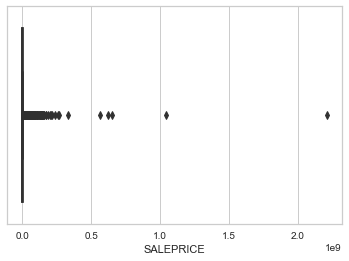

In [64]:
ax = sns.boxplot(x="SALEPRICE", data=housing_data)

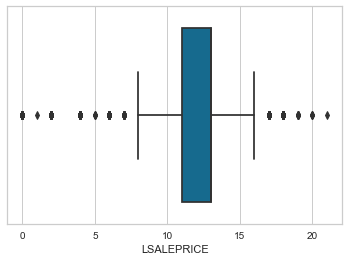

In [65]:
ax = sns.boxplot(x="LSALEPRICE", data=housing_data)

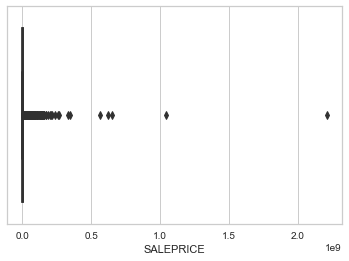

In [66]:
ax = sns.boxplot(x="SALEPRICE", data=housing_data_imputed)

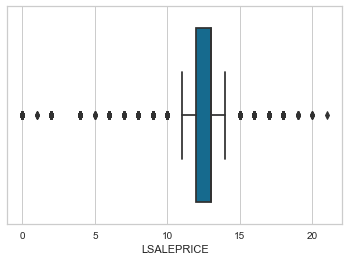

In [67]:
ax = sns.boxplot(x="LSALEPRICE", data=housing_data_imputed)

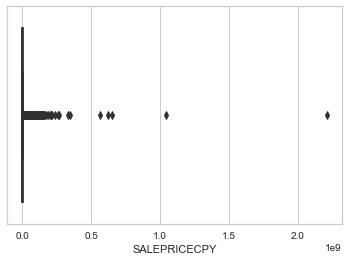

In [68]:
ax = sns.boxplot(x="SALEPRICECPY", data=housing_data_imputed)

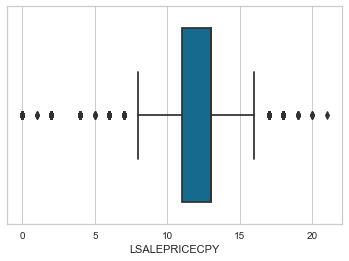

In [69]:
ax = sns.boxplot(x="LSALEPRICECPY", data=housing_data_imputed)

# Data understanding 2

>Visualize any important attributes approprieately.  Important: Provide an interpretation for any charts or graphs.

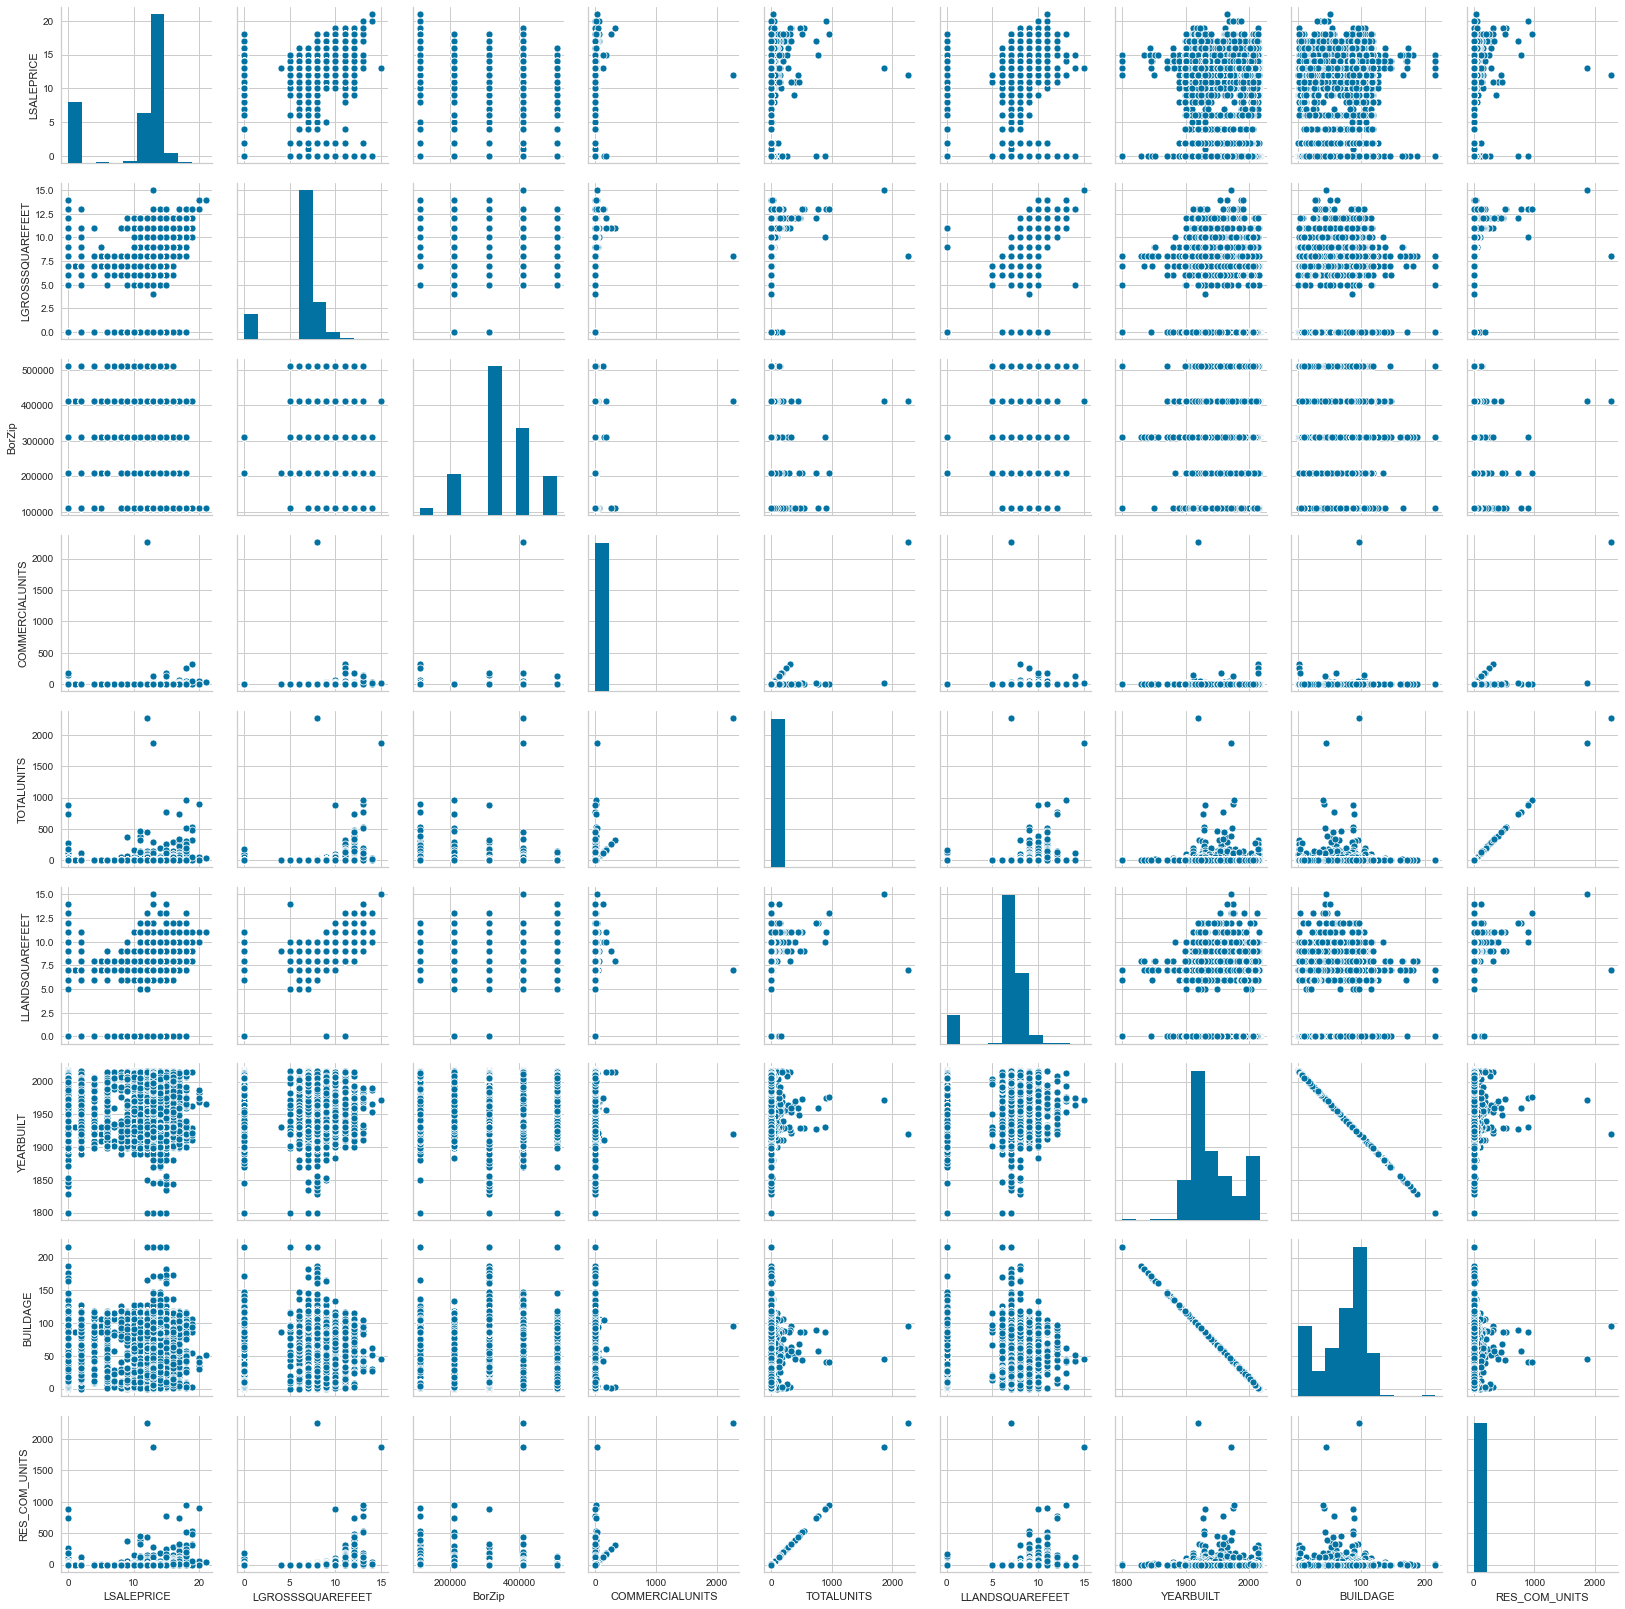

In [70]:
plot = sns.pairplot(housing_data[['LSALEPRICE',
                                  'LGROSSSQUAREFEET', 'BorZip'
                                  ,'COMMERCIALUNITS', 'TOTALUNITS'
                                  ,'LLANDSQUAREFEET', 'YEARBUILT'
                                  , 'BUILDAGE', 'RES_COM_UNITS' ]])
sns.set(rc={'figure.figsize':(80,70)})




<span style="color:green">

# Sean's Additions

## Suggested workflow for organized layout

#### Pre-Clustering
>Run All three regression models with GridSearch to pick out best performing.  We use that model and benchmark MAE going forward

#### Clustering
>1. Identify the features we want to cluster on
>2. Plot variables to visually inspect whether or not there is any clustering potential
>3. If yes, Loop through n_clusters (based on best guess) to identify highest silhoutte score
>4. Plot 'Silhouette analysis' (cluster chart and labelled scatter plot) to see size and validity of each cluster
>5. Once it's deemed reasonable based on silhouette chart, run stacked data through regression GridSearch

# Regression Benchmark Model



Recall the dynamic range of the original data is between 0e0 to 2.2e9. For the regression task of this data we will use LSALEPRICE, as the target variable. Recall this is a log base 10 transformation of the SALEPRICE target variable, except where the 0s for sale price, the value has been changed to a 1, and then the log is taken. We took this approach since it is difficult to a sale price for these types of properties, since according to the data ontology, these are property transfers that occured outside of a traditional sale. Also, by taking the log of 1, this will compute to a zero value. This has scaled our values such that we can eliminate the large dynamic range of the target variable. 



We want to predict the LSALEPRICE for a property within a borough, for this task we will use Median Absolute Error(MAE), since we are dealing with log scales as the evaulation criteria. We decided this to be the best approach as we are attempting to use various cluster techniques as a form of feature reduction to see if we are able to construct a simplier model using far less parameters. The advatage to using Median Absolute Error is we can always back transform the error of the response to gain a more meaningful insight for intrepretation, but using the median also will allow us to compare statistical significance without worying about unit transformation and intrepretation. We can simply compare error estimates. In general, the lower the MAE (Median Absolute Error) the better. 

We are using two models to judge our feature reduction through clustering, a Lasso regression and a gradient boosted regression model, as both models have parameters to allow us to penalize the model's L1 norm in the case of the Lasso regression for the sparcity of the encoded features and in the case of the GradientBoosting Regressor we can choose the number of stem and leaf nodes as well as whether the loss function is least squares or least absolute deviation, where the median of the predicted value is used. We also wanted to adjust the learning rates for the GradientBoosting Regressor in a reasonable amount of time given that we are doing 10 fold shuffle split cross validation. All models were constructed and tested using 10 fold shuffle split cross validation, unless otherwise specified (GradientBoosting),  where all features were scaled and then followed by a grid search for the optimal hyper parameters.




#### Option 1: LASSO

https://scikit-learn.org/stable/modules/linear_model.html#lasso

A Lasso Regression on scaled data, using a grid parameter search and the 10 fold 80/20 train test shuffle split.

We are testing different alphas and selection paramters. From the documentation, alpha is controlling the degree of sparsity of the estimated coefficients from our selected features. We also wanted to test whether reusing the solution of the previous call to fit as initialization effected the results, which is why we tested the warm start parameter. Also, we tested whether the selection being set to ‘random’ where a random coefficient is updated every iteration rather than looping over features sequentially as the case with cyclic made a difference.

In [71]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr)

X_regr_scl = ML_std_scalr.transform(X_regr)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   33.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  2.1min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [72]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='random', tol=0.0001, warm_start=True)

After using the outputs for the best parameters from the lasso regression and the 10 fold 80/20 train test shuffle split, the best average MAE produced is 3.5334, and we are not having a large penalty being applied to our regression parameters, alpha = 0.001

In [73]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=0, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr, cv)

mae_avg_Lasso_bse_lne = scoresResults_Lasso['MED'].mean()
scoresResults_Lasso

The average of the median absolute error for all cv folds is: 			 3.5334
*********************************************************
The average score_time for all cv folds is: 			 0.0054302
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  3.504483    0.005567
1  3.449200    0.005736
2  3.678433    0.005473
3  3.452386    0.005204
4  3.550365    0.005142
5  3.502382    0.005386
6  3.510695    0.005642
7  3.525295    0.005309
8  3.579117    0.005245
9  3.581353    0.005597

#### Option 2: Gradient Boosting Regressor

https://scikit-learn.org/stable/modules/ensemble.html#gradient-boosting

A gradient boosing regressor on scaled data, using a grid search for optimal parameters and the 3 fold 80/20 train test shuffle split. 3 fold cv is used for time savings for finding the best parameters. From the documentation, the most important parameters are the learning rate and the n_estimators, when we adjust the learning rate we are accounting for overfitting via shrinkage, and by adjusting the n_estimators parameter we are controlling the number of weak learners or regression trees, we will be controlling the size of each tree by the max_depth parameter.

In [74]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr)


X_regr_scl = ML_std_scalr.transform(X_regr)

cv = ShuffleSplit(n_splits=3, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls', 'lad']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [100, 500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[3,5]
              ,'min_samples_leaf': [10, 25]
              ,'max_leaf_nodes' : [25,40]
              ,'max_depth': [3,10]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl , y_regr)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   55.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  5.6min
[Parallel(n_jobs=8)]: Done 384 out of 384 | elapsed: 11.4min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_...
             param_grid={'criterion': ['mae'], 'learning_rate': [0.001, 0.1],
                         'loss': ['ls', 'lad'], 'max_depth': [3, 10],
              

In [75]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

After using the outputs for the best parameters from the gradient boosting regression and the 10 fold 80/20 train test shuffle split, the best average of MAE produced is 0.86553. While this model does not have a fixed dynamic range as in the case of the capped linear regression, we see it has a significant improvement over LASSO regression. Of course this comes at a significant time cost as well. 

In [76]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X_regr_scl , y_regr, cv)


mae_avg_GradientBoostingRegressor_bse_lne = scoresResults_GradientBoostingRegressor['MED'].mean()

scoresResults_GradientBoostingRegressor

The average of the median absolute error for all cv folds is: 			 0.86553
*********************************************************
The average score_time for all cv folds is: 			 0.089204
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  0.860186    0.088765
1  0.849357    0.089756
2  0.873229    0.091280
3  0.879029    0.088636
4  0.861687    0.087358
5  0.866286    0.089021
6  0.893843    0.087079
7  0.854050    0.089031
8  0.857798    0.087235
9  0.859802    0.093875

# Modeling and Evaluation 1
>Train and adjust parameters

### KMeans

<span style="color:blue">

#### 1. Loop through n_clusters to idnetify highest overall Silhouette scores


We will be using Silhouette Score to analyze the separation distance between the resulting clusters, whether the number of clusters is appropriate for our selected features. As we do not have ground truth for our clusters, we decided to use Silhoutte score for its ease of use and intreptebility for how well the clusters are fit to the data. One word of caution about using any measure that is not backed by grounded truth for clustering, is that generally speaking, density based clusters will produce more favorable scores. 


"The best value is 1 and the worst value is -1. Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.

The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually." 

##  https://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html




Based on Silhouette score, following are the top three clusters for ['COMMERCIALUNITS','BorZip'] out of all the combinations ran. We shall further plot top three n_cluster values to visually inspect for ['COMMERCIALUNITS','BorZip'] cluster


Number of clusters =  7
Silhouette score =  0.9755055033623479

Number of clusters =  9
Silhouette score =  0.976567861449096

Number of clusters =  19
Silhouette score =  0.9697831432578858




In [82]:
from sklearn.cluster import KMeans
from sklearn import metrics 



clusters = np.arange(7, 21, 2)

C=[]


X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]
X2 = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X3 = X_scl_df[['TOTALUNITS', 'BorZip']]
X4 = X_scl_df[['LLANDSQUAREFEET', 'BorZip']]
X5 = X_scl_df[['YEARBUILT', 'BorZip']]
X6 = X_scl_df[['BUILDAGE', 'BorZip']]
X7 = X_scl_df[['RES_COM_UNITS', 'BorZip']]
X8 = X_scl_df[['RES_COM_UNITS', 'BUILDAGE']]
X9 = X_scl_df[['RES_COM_UNITS', 'YEARBUILT']]

C.append(X1)
C.append(X2)
C.append(X3)
C.append(X4)
C.append(X5)
C.append(X6)
C.append(X7)
C.append(X8)
C.append(X9)

 
for x in C:
    
    print('----------------------------------')
    print(x.columns.values)
    print('----------------------------------')
    scores = []
    for i in clusters: 
        
        cls = KMeans(n_clusters=i, init='k-means++',random_state=1)
        cls.fit(x)
        score = metrics.silhouette_score(x, cls.labels_, metric = 'euclidean', sample_size = len(x)) 

        print('\nNumber of clusters = ', i)
        print('Silhouette score = ', score)

        #scores.append(score)
    
    
    #plt.figure()
    #plt.bar(clusters, scores, width=0.6, color='k', align='center')
    #plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()
  

----------------------------------
['LGROSSSQUAREFEET' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.8458127676509258

Number of clusters =  9
Silhouette score =  0.8569046941186725

Number of clusters =  11
Silhouette score =  0.8753121178128109

Number of clusters =  13
Silhouette score =  0.9114474038939524

Number of clusters =  15
Silhouette score =  0.9229506351748196

Number of clusters =  17
Silhouette score =  0.9531155028329205

Number of clusters =  19
Silhouette score =  0.9646583329413647
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.9755055033623473

Number of clusters =  9
Silhouette score =  0.9765678614490959

Number of clusters =  11
Silhouette score =  0.9638538075190235

Number of clusters =  13
Silhouette score =  0.9643303052968464

Number of clusters =  15
Silhouette score =  0.9633527604418575

Number of clusters =  17

<span style="color:blue">

#### 2. Plot top three n_cluster values to visually inspect clusters




Below we use KMeans and Agglomerative clustering techniques to evaluate and compare the clustering integrity based on the most promising silhouette scores from above. 

<span style="color:red">
    
KMeans cluster inspection / Silhouette graphs

Automatically created module for IPython interactive environment
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------
For n_clusters = 7 The average silhouette_score is : 0.9755055033623473
For n_clusters = 9 The average silhouette_score is : 0.9765678614490957
For n_clusters = 19 The average silhouette_score is : 0.9655880511965553


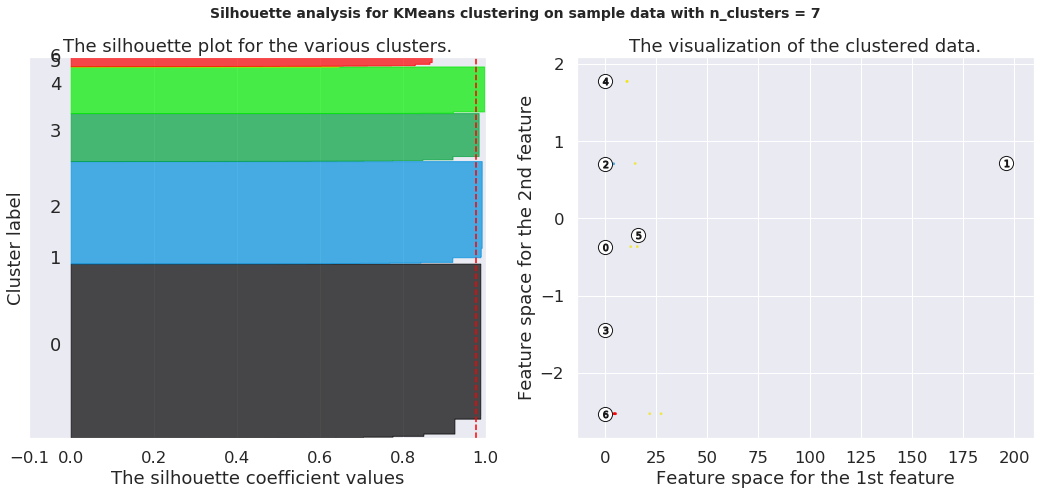

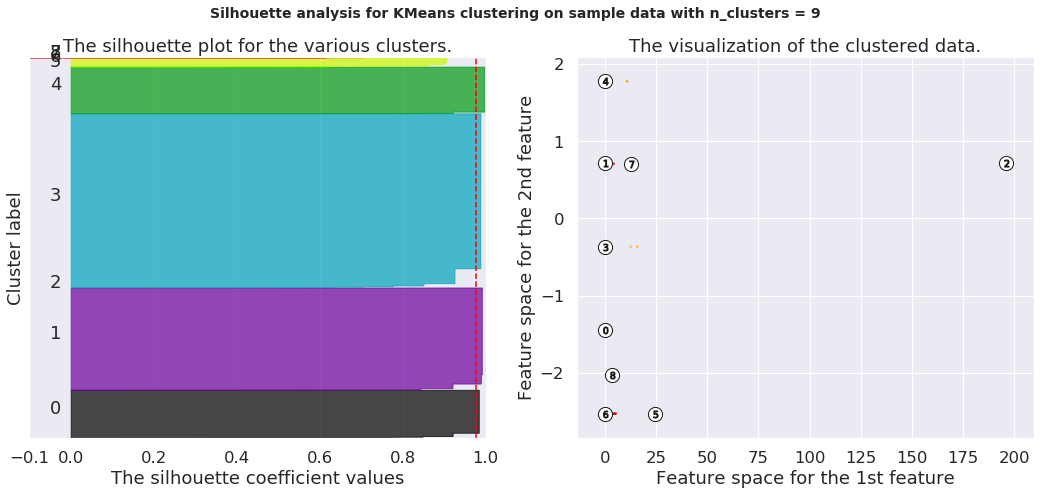

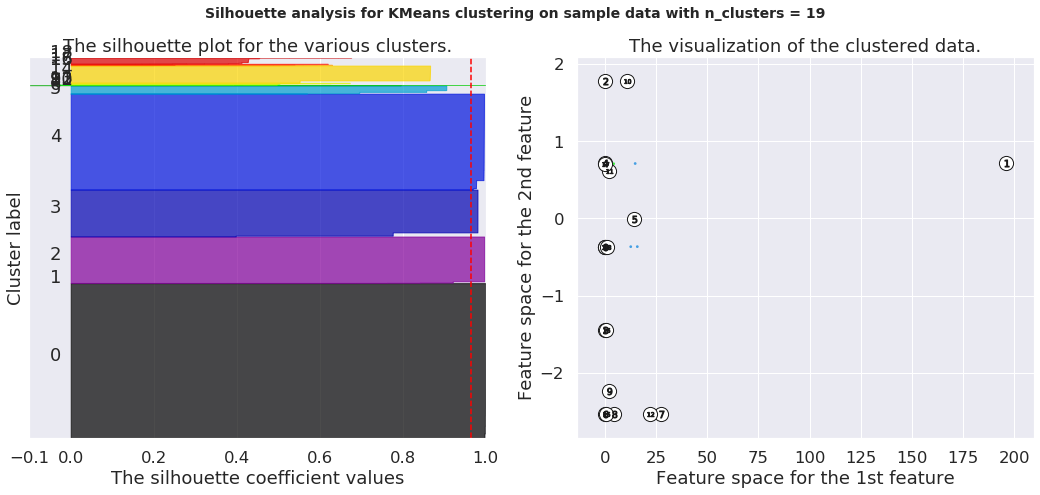

In [83]:

#Code adopted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.



X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]

y = y_scl

range_n_clusters = [7, 9, 19]

    
print('----------------------------------')
print(X.columns.values)
print('----------------------------------')

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

It appears that 9 clusters has the most viable clusters

<span style="color:blue">

#### 3. Test reduced dataset against regression model and compare to benchmark


####  Gradient Boosting Regressor - KMeans

In [87]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=9, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

cv = ShuffleSplit(n_splits=3, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls', 'lad']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [100, 500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[3,5]
              ,'min_samples_leaf': [10, 25]
              ,'max_leaf_nodes' : [25,40]
              ,'max_depth': [3,10]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X , y)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.4s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.4min
[Parallel(n_jobs=8)]: Done 384 out of 384 | elapsed:  2.9min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_...
             param_grid={'criterion': ['mae'], 'learning_rate': [0.001, 0.1],
                         'loss': ['ls', 'lad'], 'max_depth': [3, 10],
              

In [88]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [89]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

from sklearn.cluster import KMeans

X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=9, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))


cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X , y, cv)


mae_avg_GradientBoostingRegressor_kmean_clust = scoresResults_GradientBoostingRegressor['MED'].mean()
scoresResults_GradientBoostingRegressor

The average of the median absolute error for all cv folds is: 			 0.82004
*********************************************************
The average score_time for all cv folds is: 			 0.054832
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  0.748993    0.055575
1  0.820999    0.055217
2  0.832028    0.053327
3  0.832974    0.054412
4  0.791708    0.054954
5  0.842702    0.054528
6  0.880589    0.054240
7  0.804969    0.055001
8  0.795181    0.056803
9  0.850286    0.054265

*Benchmark GBR Median Absolute Error (10-fold CV): 0.87*

*Clustered Dataset based on COMMERCIAL UNITS and BorZip (Kmeans 9 clusters): 0.82*

# Agglomerative

<span style="color:red">
    
### Agglomerative Clustering
Takes about 1.25 hours to run

In [ ]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics 



clusters = np.arange(7, 21, 2)

C=[]


X1 = X_scl_df[['LGROSSSQUAREFEET', 'BorZip']]
X2 = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X3 = X_scl_df[['TOTALUNITS', 'BorZip']]
X4 = X_scl_df[['LLANDSQUAREFEET', 'BorZip']]
X5 = X_scl_df[['YEARBUILT', 'BorZip']]
X6 = X_scl_df[['BUILDAGE', 'BorZip']]
X7 = X_scl_df[['RES_COM_UNITS', 'BorZip']]
X8 = X_scl_df[['RES_COM_UNITS', 'BUILDAGE']]
X9 = X_scl_df[['RES_COM_UNITS', 'YEARBUILT']]

C.append(X1)
C.append(X2)
C.append(X3)
C.append(X4)
C.append(X5)
C.append(X6)
C.append(X7)
C.append(X8)
C.append(X9)

 
for x in C:
    
    print('----------------------------------')
    print(x.columns.values)
    print('----------------------------------')
    scores = []
    for i in clusters: 
        
        cls = AgglomerativeClustering(n_clusters=i, affinity = 'euclidean', linkage='ward')
        cls.fit(x)
        score = metrics.silhouette_score(x, cls.labels_, metric = 'euclidean', sample_size = len(x)) 

        print('\nNumber of clusters = ', i)
        print('Silhouette score = ', score)

        #scores.append(score)
    
    
    #plt.figure()
    #plt.bar(clusters, scores, width=0.6, color='k', align='center')
    #plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()
  

<span style="color:red">
    
Agglomerative cluster inspection of top three silhouette scores

Automatically created module for IPython interactive environment
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------
For n_clusters = 7 The average silhouette_score is : 0.9747939973698083
For n_clusters = 9 The average silhouette_score is : 0.9756622513207522
For n_clusters = 11 The average silhouette_score is : 0.9773212288032548


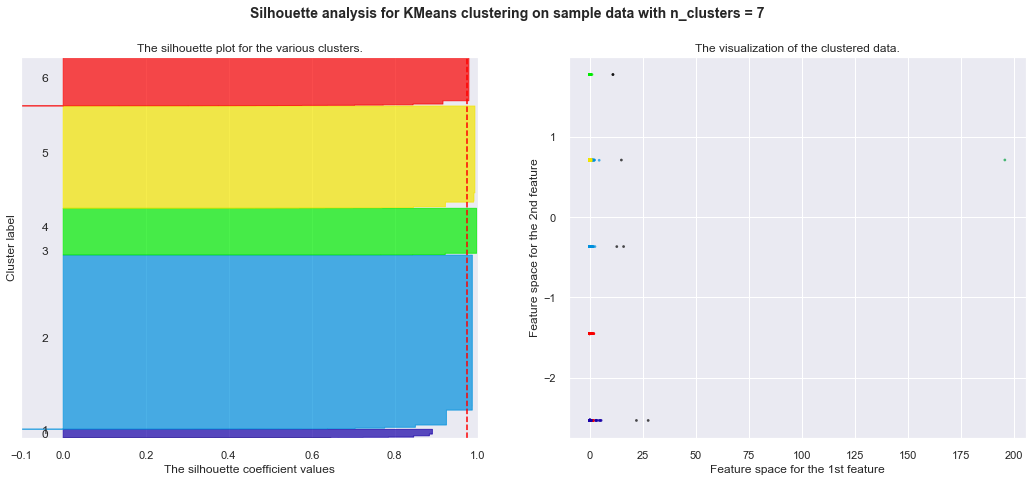

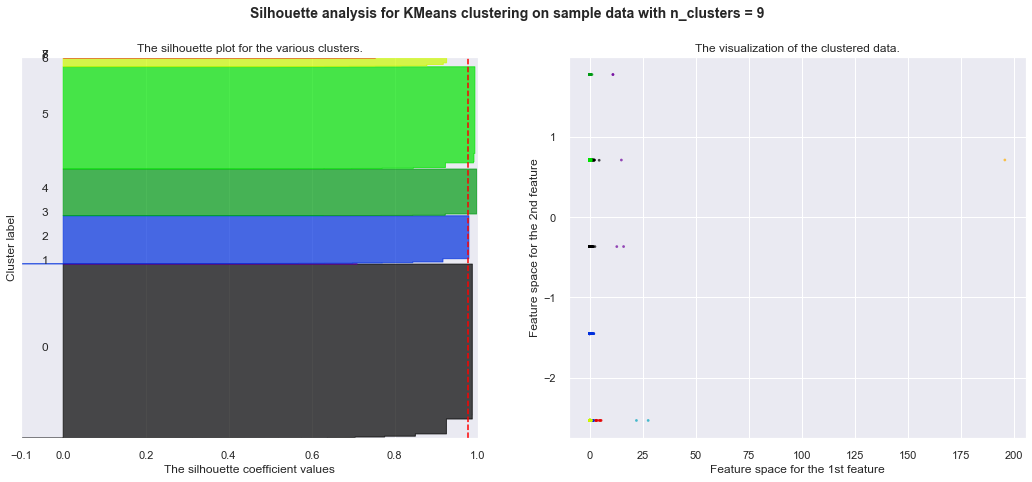

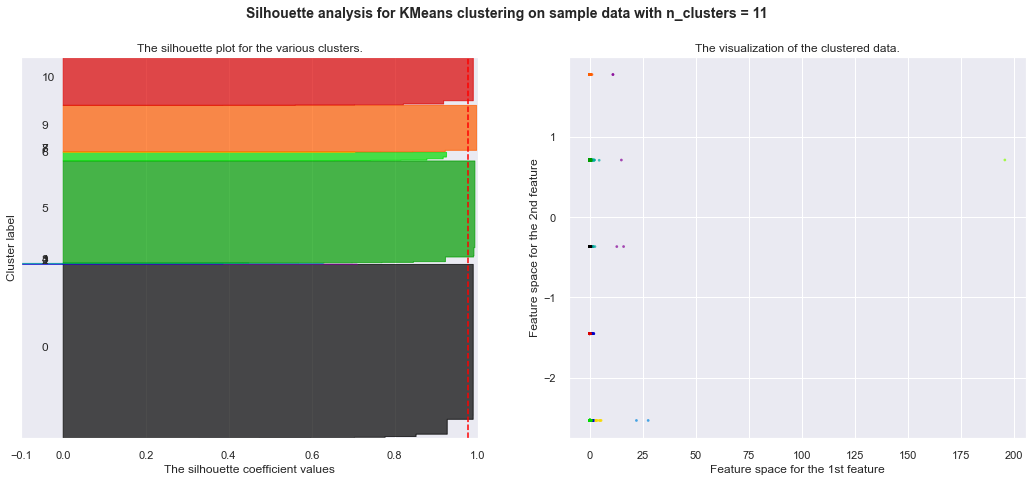

In [86]:
#Code adopted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html
from sklearn.cluster import AgglomerativeClustering
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.



X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]

y = y_scl

range_n_clusters = [7, 9, 11]

    
print('----------------------------------')
print(X.columns.values)
print('----------------------------------')

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity = 'euclidean', linkage='ward')
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')




    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

####  Gradient Boosting Regressor - Agglomerative

In [82]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=9, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from agglomerative clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

cv = ShuffleSplit(n_splits=3, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls', 'lad']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [100, 500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[3,5]
              ,'min_samples_leaf': [10, 25]
              ,'max_leaf_nodes' : [25,40]
              ,'max_depth': [3,10]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X , y)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   37.8s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  4.0min
[Parallel(n_jobs=8)]: Done 384 out of 384 | elapsed:  8.1min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=959, test_size=0.2, train_size=None),
             error_score='raise-deprecating',
             estimator=GradientBoostingRegressor(alpha=0.9,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 mi...
             param_grid={'criterion': ['mae'], 'learning_rate': [0.001, 0.1],
                         'loss': ['ls', 'lad'], 'max_depth': [3, 10],
               

In [83]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto', random_state=0,
                          subsample=0.01, tol=0.0001, validation_fraction=0.1,
                          verbose=0, warm_start=False)

In [85]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

from sklearn.cluster import KMeans

X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=9, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))


cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
regEstimator = GradientBoostingRegressor(alpha=0.9, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X , y, cv)


mae_avg_GradientBoostingRegressor_agg_clust = scoresResults_GradientBoostingRegressor['MED'].mean()
scoresResults_GradientBoostingRegressor

The average of the median absolute error for all cv folds is: 			 0.81998
*********************************************************
The average score_time for all cv folds is: 			 0.14963
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  0.741597    0.155566
1  0.836162    0.146972
2  0.839239    0.151052
3  0.822380    0.151242
4  0.799449    0.152137
5  0.847086    0.146741
6  0.885279    0.151981
7  0.780507    0.149278
8  0.787414    0.150558
9  0.860694    0.140769

*Benchmark GBR Median Absolute Error (10-fold CV): 0.87*

*Clustered Dataset based on COMMERCIAL UNITS and BorZip (Agglomerative 9 clusters): 0.82*

<span style="color:red">

# 19 Cluster 10-Fold CV 

Should we run 19 thorugh GBR too since it was included in the statistical comparison?

In [86]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

from sklearn.cluster import KMeans

X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))


cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X , y, cv)


mae_avg_GradientBoostingRegressor_kmean_clust = scoresResults_GradientBoostingRegressor['MED'].mean()
scoresResults_GradientBoostingRegressor

TypeError: __init__() got an unexpected keyword argument 'ccp_alpha'

# Model and Evaluation 2
>Evaluate and Compare

#### Statistical Comparison

To compare our two candidates against our benchmark Gradient Bosted Regressor score, we fit all three models. 

###### Benchmark Gradient Boosted Regressor model

In [ ]:
#Adapted from 
#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb

#Gradient Boosting

ML_std_scalr.fit(X_regr)


X_regr_scl = ML_std_scalr.transform(X_regr)

regr1 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)






cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err1 = cross_val_score(regr1 , X_regr_scl, y_regr, cv=cv, scoring = 'neg_median_absolute_error')

###### KMeans Model (n_clusters = 9)

In [ ]:
# Gradient Boosting with clustering


from sklearn.cluster import KMeans


X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=9, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))





regr2 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err2 = cross_val_score(regr2, X, y, cv=cv, scoring = 'neg_median_absolute_error')

###### Agglomerative

In [ ]:
# Gradient Boosting with clustering

from sklearn.cluster import KMeans

X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = AgglomerativeClustering(n_clusters=9, affinity = 'euclidean', linkage='ward')
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

ml_df_features = pd.concat([X1, pd.get_dummies(newfeature)])


y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))





regr3 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features='auto', max_leaf_nodes=40,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='auto',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err3 = cross_val_score(regr3, X, y, cv=cv, scoring = 'neg_median_absolute_error')

### Statistical Test 1: Benchmark vs 9-Cluster Dataset

First, we would like to statistically test if the Gradient Boosting regressor model using the clutered dataset (9 clusters) is as (or more) accurate at predicting the SALEPRICE of a given property.  Our null and alternative hypotheses are as follows:

*h0: The Median Absolute Error of the Gradient Boosting Regressor equals the Median Absolute Error of the Gradient Boosting Regressor with reduced cluster featuers*

*ha: The mean Median Absolute Error of the models are different*

In [ ]:
# wanting to check 3 models accross 10 folds, therefore t = 2.764 with alpha = 0.05/2 and degrees of freedom = 10 
# we reject h0 the models are statistically different, as zero is not in the interval, The LASSO model is the better 
#regressor model. 


t =  2.764 / np.sqrt(10)

e = abs(reg_err1) - abs(reg_err2)

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (abs(np.mean(reg_err1)), abs(np.mean(reg_err2)))

Comparing GradientBoostingRegressor and GradientBoostingRegressor with reduced features from clustering, the 95% confidence interval [0.0202, 0.0707] shows that the interval doesn't includes zero, which implies that the two models are statistically different and we reject null hypothesis. There is evidence to suggest the Gradient Boosting Regressor with reduced features from clustering is statistically better at prediciting sale price. 

### Statistical Test 2: 9-Cluster Dataset vs 19-Cluster Dataset

Now that it shows that the clustered dataset is better at predicting SALEPRICE, we determine if there is any statistical significance between the difference of using 9 or 19 clusters.  The null and alternative hypothesis are as follows:

*h0: The Median Absolute Error of the Gradient Boosting Regressor with reduced cluster features is equal to the Median Absolute Error of the Gradient Boosting Regressor with imputed values* 

*ha: The mean Median Absolute Error of the models are different*

In [ ]:
t =  2.764 / np.sqrt(10)

e = abs(reg_err2) - abs(reg_err3) 

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (abs(np.mean(reg_err2)), abs(np.mean(reg_err3)))

Comparing GradientBoostingRegressor with 9 clusters and GradientBoostingRegressor with 19 clusters from the imputed data, the 95% confidence interval [0.6137, 0.70520] shows that the interval doesn't includes zero, which implies that the two models are statistically different and we reject null hypothesis. There is evidence to suggest the Gradient Boosting Regressor with 19 clusters from the imputed data is statistically better at prediciting the log of sale price. 

# Modeling and Evaluation 3
>Visualize Results

<span style="color:red">

# Fill in commentary on visualization here


In [90]:
from sklearn.cluster import KMeans

X =  X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

ml_df_features = pd.concat([X1, pd.get_dummies(newfeature)])


y = y_scl_impute
X = X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

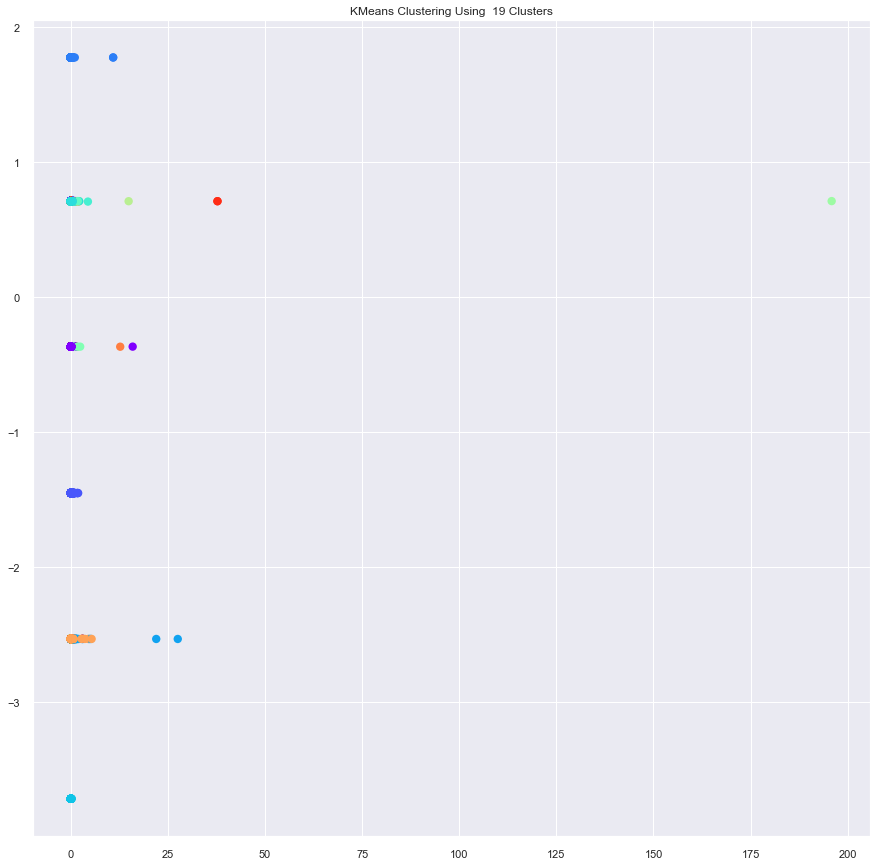

In [91]:
labels = cls.fit_predict(X1)
plt.figure(figsize=(15, 15))
plt.scatter(X[:, 0], X[:, 1], c=labels,
                    cmap=plt.cm.rainbow, s=70, linewidths=0)
plt.title('KMeans Clustering Using  %d Clusters' % 19)
plt.show()

# Modeling and Evaluation 4
>Summarize the Ramifications


>Be critical of your performance and tell the reader how you current model might be usable by other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?

#### PCA on whole dataset vs PCA on clustered dataset

The goal of the experiment was to see if it was possible to use clustering to greatly reduce the number of features necessary to predict the SALEPRICE of a certian propperty using Gradient Boosted Regressor.  Based on the statistical results highlighted in Modeling and Evaluation 2, that objective has been completed by creating a model that has 21 fetures compared to the original dataset with 688 features by clustering off of COMMERICALUNITS and the engineered feature of BorZip.  It is likely that our model is not the 'global minimum' in terms of Median Absolute Error and all of the possible variable permuations that could have been clustered on, but it was a success nonetheless. 

The accomplishment of this goal has important ramifications on the use of our application.  Firstly, if a user is attempting to find the approxmiate value of a property in New York City, they likely do not possess all 22 of the base attributes needed to extrapolate out to the full 688 feature dataset.  Information such as the property's tax class as of the last transaction, lot number, or builidng class at the time of the last sale are not readily available datapoints that our prospective useres can obtain easily.  

Because our model allows the user to be more accurate based off of the number of commericial units and a combination of the Borough and Zipcode, it drastically increase the usability of our model, and therefore likely expnding our potential user base.  The ease of use expands the range of those able to participate from realtors and real estate experts to those who are less specialized and who are unable or unwilling to track down all of the necessary datapoints.  

Aside form increasing the usability of our appication, the goal of using clustering as a feature reduction method was to increase the effiency of the regression model. Even when using a feature reduction technique such as Principal Componenet Analysis, using regresson models such as Gradient Boosted Regressor can still be inefficient.  Those inefficencies are highlighted below as 400 components are required to explain 90% of the variance of the full dataset.  When using a regression method such as Gradient Boosted Regressor, using 400 variables can be computationally expensive.  

Cumulative Explained variance explained with : 400 components: 0.9026654043733697


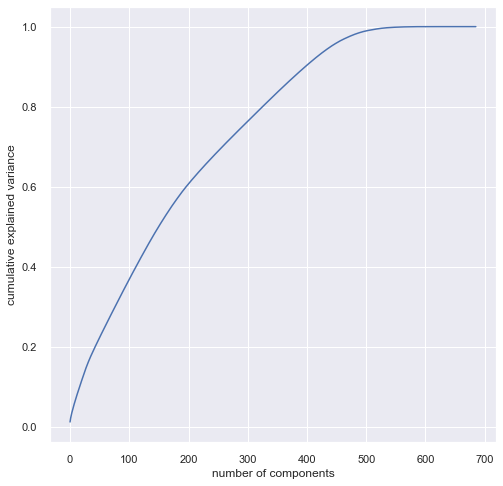

In [75]:
plot_pca(X_regr_scl, 400)

<span style="color:green">
    
# --------------------------------------END OF WORKFLOW ----------------------------------------

## Exceptional Work    -- added by Rajesh

#### LASSO ON IMPUTED DATA WITH ALL THE FIELDS

https://scikit-learn.org/stable/modules/linear_model.html#lasso

A Lasso Regression on scaled data imputed data, using a grid parameter search and the 10 fold 80/20 train test shuffle split. Recall this data was imputed with the zipcode median where there was a 0 dollar value, a missing year, etc. We are wanting to test to see if our average of median absolute error increased or decreased the model's performance. 

We are testing different alphas and selection paramters. From the documentation, alpha is controlling the degree of sparsity of the estimated coefficients from our selected features. We also wanted to test whether reusing the solution of the previous call to fit as initialization effected the results, which is why we tested the warm start parameter. Also, we tested whether the selection being set to ‘random’ where a random coefficient is updated every iteration rather than looping over features sequentially as the case with cyclic made a difference.

In [90]:

#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

ML_std_scalr.fit(X_regr_impute)

X_regr_scl = ML_std_scalr.transform(X_regr_impute)

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr_impute)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   45.5s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.8min
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:  2.9min finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [91]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=True)

After using the outputs for the best parameters from the lasso regression and the 10 fold 80/20 train test shuffle split, the best average of MAE produced is 0.37. It would seem by imputing all of the missing values with the zipcode median drastically improved the model performance.  

In [92]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr_impute, cv)

mae_avg_Lasso_bse_lne_impute = scoresResults_Lasso['MED'].mean()
scoresResults_Lasso

The average of the median absolute error for all cv folds is: 			 0.37035
*********************************************************
The average score_time for all cv folds is: 			 0.0069349
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  0.372838    0.006767
1  0.367926    0.006688
2  0.366870    0.006685
3  0.370533    0.006724
4  0.373305    0.006780
5  0.368505    0.006781
6  0.368782    0.008838
7  0.369947    0.006702
8  0.368276    0.006688
9  0.376469    0.006696

In [93]:
ML_std_scalr.fit(X_regr_impute)

X_regr_scl = ML_std_scalr.transform(X_regr_impute)

cv = ShuffleSplit(n_splits=3, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls', 'lad']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [100, 500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[3,5]
              ,'min_samples_leaf': [10, 25]
              ,'max_leaf_nodes' : [25,40]
              ,'max_depth': [3,10]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X_regr_scl,y_regr_impute)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  1.2min
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  7.9min
[Parallel(n_jobs=8)]: Done 384 out of 384 | elapsed: 16.0min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_...
             param_grid={'criterion': ['mae'], 'learning_rate': [0.001, 0.1],
                         'loss': ['ls', 'lad'], 'max_depth': [3, 10],
              

In [94]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [95]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor_bse_lne_impute = EvaluateRegressionEstimator(regEstimator, X_regr_scl,y_regr_impute, cv)


mae_avg_GradientBoostingRegressor = scoresResults_GradientBoostingRegressor['MED'].mean()
scoresResults_GradientBoostingRegressor

The average of the median absolute error for all cv folds is: 			 0.25904
*********************************************************
The average score_time for all cv folds is: 			 0.093584
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  0.748993    0.055575
1  0.820999    0.055217
2  0.832028    0.053327
3  0.832974    0.054412
4  0.791708    0.054954
5  0.842702    0.054528
6  0.880589    0.054240
7  0.804969    0.055001
8  0.795181    0.056803
9  0.850286    0.054265

## KMEAN

<span style="color:blue">

#### 1. Loop through n_clusters to idnetify highest overall Silhouette score

We will be using Silhouette analysis to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. 

Based on Silhouette score, following are the top three clusters for ['COMMERCIALUNITS','BorZip'] out of all the combinations ran. We shall further plot top three n_cluster values to visually inspect for ['COMMERCIALUNITS','BorZip'] cluster



['COMMERCIALUNITS' 'BorZip']

Number of clusters =  11
Silhouette score =  0.9794471221553575

Number of clusters =  9
Silhouette score =  0.9785340412992206


['LLANDSQUAREFEET' 'BorZip']

Number of clusters =  19
Silhouette score =  0.9801108849061608






In [96]:
from sklearn.cluster import KMeans
from sklearn import metrics 



clusters = np.arange(7, 21, 2)

C=[]


X1 = X_scl_df_impute[['LGROSSSQUAREFEET', 'BorZip']]
X2 = X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]
X3 = X_scl_df_impute[['TOTALUNITS', 'BorZip']]
X4 = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X5 = X_scl_df_impute[['YEARBUILT', 'BorZip']]
X6 = X_scl_df_impute[['BUILDAGE', 'BorZip']]
X7 = X_scl_df_impute[['RES_COM_UNITS', 'BorZip']]
X8 = X_scl_df_impute[['RES_COM_UNITS', 'BUILDAGE']]
X9 = X_scl_df_impute[['RES_COM_UNITS', 'YEARBUILT']]

C.append(X1)
C.append(X2)
C.append(X3)
C.append(X4)
C.append(X5)
C.append(X6)
C.append(X7)
C.append(X8)
C.append(X9)

 
for x in C:
    
    print('----------------------------------')
    print(x.columns.values)
    print('----------------------------------')
    scores = []
    for i in clusters: 
        
        cls = KMeans(n_clusters=i, init='k-means++',random_state=1)
        cls.fit(x)
        score = metrics.silhouette_score(x, cls.labels_, metric = 'euclidean', sample_size = len(x)) 

        print('\nNumber of clusters = ', i)
        print('Silhouette score = ', score)

        #scores.append(score)
    
    
    #plt.figure()
    #plt.bar(clusters, scores, width=0.6, color='k', align='center')
    #plt.title('Silhouette score vs number of clusters')

# plt.figure()
# plt.scatter(X1[:,0], X1[:,1], color = 'k', s=30, marker = 'o', facecolors='none')
# x_min, x_max = min(X1[:,0]) - 1, max(X1[:,0]) + 1 
# y_min, y_max = min(X1[:,1]) - 1 , max(X1[:,1]) + 1 
# plt.title('Input Cluster')
# plt.xlim(x_min, x_max)
# plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())

# plt.show()
  

----------------------------------
['LGROSSSQUAREFEET' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.8609838756918881

Number of clusters =  9
Silhouette score =  0.8759844794722308

Number of clusters =  11
Silhouette score =  0.8930330271295761

Number of clusters =  13
Silhouette score =  0.926365894585826

Number of clusters =  15
Silhouette score =  0.952215930749697

Number of clusters =  17
Silhouette score =  0.9592370794353339

Number of clusters =  19
Silhouette score =  0.9696190475412942
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------

Number of clusters =  7
Silhouette score =  0.9696294058447249

Number of clusters =  9
Silhouette score =  0.9785340412992042

Number of clusters =  11
Silhouette score =  0.9794471221553426

Number of clusters =  13
Silhouette score =  0.9698642417497525

Number of clusters =  15
Silhouette score =  0.9581066280549672

Number of clusters =  17
S

<span style="color:blue">

#### 2. Plot top three n_cluster values to visually inspect clusters

Automatically created module for IPython interactive environment
----------------------------------
['COMMERCIALUNITS' 'BorZip']
----------------------------------
For n_clusters = 9 The average silhouette_score is : 0.9785340412992054
For n_clusters = 11 The average silhouette_score is : 0.9794471221553319
----------------------------------
['LLANDSQUAREFEET' 'BorZip']
----------------------------------
For n_clusters = 19 The average silhouette_score is : 0.9823098325578827


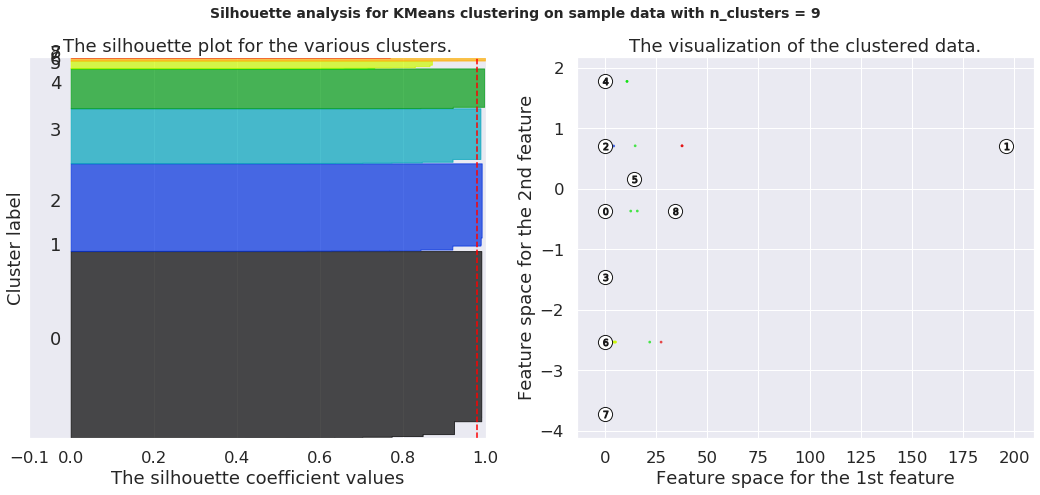

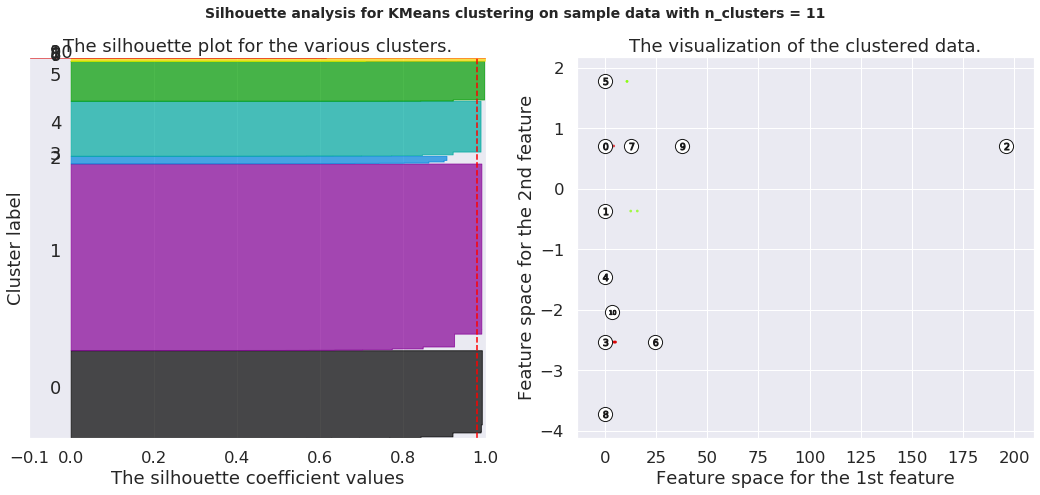

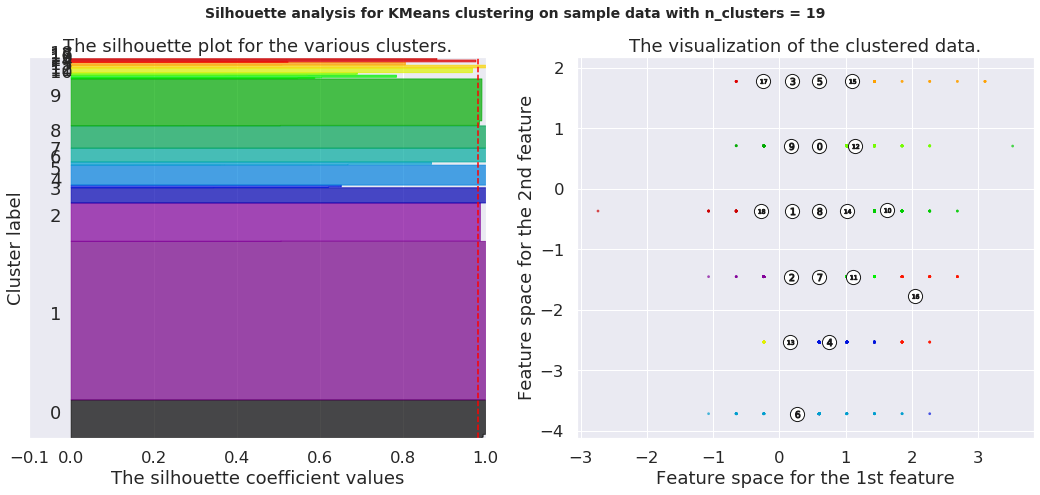

In [97]:

#Code adopted from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

print(__doc__)

# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.


X = X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]

y = y_scl_impute

range_n_clusters = [9, 11]

print('----------------------------------')
print(X.columns.values)
print('----------------------------------')

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X.iloc[:, 0], X.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    
    
    
X1 = X_scl_df_impute[['COMMERCIALUNITS', 'BorZip']]

range_n_clusters1 = [19]
    
    
print('----------------------------------')
print(X1.columns.values)
print('----------------------------------')

for n_clusters in range_n_clusters1:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X1) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X1)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X1, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X1, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X1.iloc[:, 0], X1.iloc[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

It appears that 19 clusters has the most viable clusters

<span style="color:blue">

#### 3. Test reduced dataset against regression model and compare to benchmark

Lasso Regression

In [98]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Recluster and stack cluster values onto dataset


X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

#Run clustered dataset through GridSearch and regression

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
reg = Lasso(fit_intercept=True, normalize=True,copy_X=True
          , max_iter=10000, precompute=True, tol=0.0001, random_state=0)

#Test parameters 
alpha = [0.001, 0.1, 1, 10, 20]
selection = ['cyclic','random']
warm_start = [True, False]
parameters = {'alpha': alpha, 'selection': selection, 'warm_start': warm_start}

#Create a grid search object using the parameters above
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=reg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X,y)

Fitting 10 folds for each of 20 candidates, totalling 200 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    1.2s
[Parallel(n_jobs=8)]: Done 200 out of 200 | elapsed:    3.0s finished


GridSearchCV(cv=ShuffleSplit(n_splits=10, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True,
                             max_iter=10000, normalize=True, positive=False,
                             precompute=True, random_state=0,
                             selection='cyclic', tol=0.0001, warm_start=False),
             iid='deprecated', n_jobs=8,
             param_grid={'alpha': [0.001, 0.1, 1, 10, 20],
                         'selection': ['cyclic', 'random'],
                         'warm_start': [True, False]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=make_scorer(mean_absolute_error, greater_is_better=False),
             verbose=1)

In [99]:
regGridSearch.best_estimator_

Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000,
      normalize=True, positive=False, precompute=True, random_state=0,
      selection='cyclic', tol=0.0001, warm_start=True)

In [100]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

regEstimator = Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=10000, normalize=True,
      positive=False, precompute=True, random_state=959, selection='random',
      tol=0.0001, warm_start=True)
#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_Lasso = EvaluateRegressionEstimator(regEstimator, X, y, cv)

mae_avg_Lasso_kmean_clust_impute = scoresResults_Lasso['MED'].mean()
scoresResults_Lasso

The average of the median absolute error for all cv folds is: 			 0.32871
*********************************************************
The average score_time for all cv folds is: 			 0.001185
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  0.331237    0.000976
1  0.323820    0.001110
2  0.331328    0.001274
3  0.330838    0.001110
4  0.329613    0.001349
5  0.322905    0.001345
6  0.329655    0.001379
7  0.327010    0.001398
8  0.327527    0.000867
9  0.333175    0.001043

Baseline LASSO: The median absolute error for all cv folds is: 0.36936

KMeans, n_clusters=19
The median absolute error for all cv folds is:0.32871

In [101]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))


cv = ShuffleSplit(n_splits=3, test_size=0.20, random_state=959)
linreg = GradientBoostingRegressor()

parameters = { 'loss' : ['ls', 'lad']
              ,'learning_rate' : [1e-3, 1e-1]
              ,'n_estimators': [100, 500] 
              ,'criterion': ['mae']
              ,'min_samples_split':[3,5]
              ,'min_samples_leaf': [10, 25]
              ,'max_leaf_nodes' : [25,40]
              ,'max_depth': [3,10]
              ,'max_features' : ['auto']
              ,'subsample' : [1e-2]
              ,'random_state': [0]
             }

#Create a grid search object using the  
from sklearn.model_selection import GridSearchCV
regGridSearch = GridSearchCV(estimator=linreg
                   , n_jobs=8 # jobs to run in parallel
                   , verbose=1 # low verbosity
                   , param_grid=parameters
                   , cv=cv # KFolds = 10
                   , scoring=mae_scorer)

#Perform hyperparameter search to find the best combination of parameters for our data
regGridSearch.fit(X , y)

Fitting 3 folds for each of 128 candidates, totalling 384 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   17.6s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  2.0min
[Parallel(n_jobs=8)]: Done 384 out of 384 | elapsed:  4.2min finished


GridSearchCV(cv=ShuffleSplit(n_splits=3, random_state=959, test_size=0.2, train_size=None),
             error_score=nan,
             estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                                 criterion='friedman_mse',
                                                 init=None, learning_rate=0.1,
                                                 loss='ls', max_depth=3,
                                                 max_features=None,
                                                 max_leaf_nodes=None,
                                                 min_impurity_decrease=0.0,
                                                 min_impurity_split=None,
                                                 min_samples_leaf=1,
                                                 min_...
             param_grid={'criterion': ['mae'], 'learning_rate': [0.001, 0.1],
                         'loss': ['ls', 'lad'], 'max_depth': [3, 10],
              

In [102]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb
#Display the best estimator parameters
regGridSearch.best_estimator_

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features='auto', max_leaf_nodes=40,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [103]:
#Adopted from https://github.com/jakemdrew/DataMiningNotebooks/blob/master/07.%20Regression.ipynb

#Create a regression estimator with best parameters for cross validation

from sklearn.cluster import KMeans

X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)
regEstimator = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features='auto', max_leaf_nodes=40,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

#Evaluate the regression estimator above using our pre-defined cross validation and scoring metrics.
scoresResults_GradientBoostingRegressor = EvaluateRegressionEstimator(regEstimator, X , y, cv)


mae_avg_GradientBoostingRegressor_kmean_clust_impute = scoresResults_GradientBoostingRegressor['MED'].mean()
scoresResults_GradientBoostingRegressor

The average of the median absolute error for all cv folds is: 			 0.1606
*********************************************************
The average score_time for all cv folds is: 			 0.14716
*********************************************************
Cross Validation Fold Mean Error Scores


MED  SCORE_TIME
0  0.204419    0.149160
1  0.184089    0.146440
2  0.148515    0.148039
3  0.166518    0.146726
4  0.179437    0.146194
5  0.148554    0.146508
6  0.142500    0.146643
7  0.153289    0.146688
8  0.145232    0.146642
9  0.133397    0.148600

## Feature Importances 

# Imputed Data 

Will use 3 fold CV as this takes 40 minutes to run with 10 fold cv

In [67]:
#https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
#https://nbviewer.jupyter.org/github/jakemdrew/EducationDataNC/blob/master/2017/Models/2017SegregatedElementarySchoolCampuses.ipynb
#Create a regression estimator with best parameters for cross validation

from sklearn.cluster import KMeans

X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

ml_df_features = pd.concat([X1, pd.get_dummies(newfeature)])


y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))


cv = ShuffleSplit(n_splits=3, test_size=0.20, random_state=959)

regrgrad = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features='auto', max_leaf_nodes=40,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

rfecv = RFECV(estimator=regrgrad, step=1, cv=cv, scoring='neg_median_absolute_error', n_jobs=-1)
rfecv.fit(X,y)

RFECV(cv=ShuffleSplit(n_splits=3, random_state=959, test_size=0.2, train_size=None),
      estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                          criterion='mae', init=None,
                                          learning_rate=0.1, loss='ls',
                                          max_depth=10, max_features='auto',
                                          max_leaf_nodes=40,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=10,
                                          min_samples_split=3,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=500,
                                          n_iter_no_change=None,
                                          presort='deprecated', random_state=0,
                            

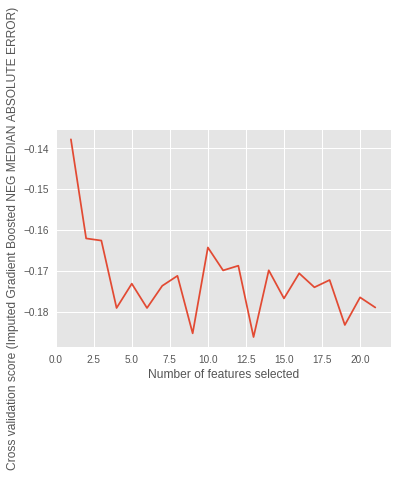

In [70]:
%matplotlib inline
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (Imputed Gradient Boosted NEG MEDIAN ABSOLUTE ERROR)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [78]:
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':ml_df_features.columns, 'MAE':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='MAE', inplace=True, ascending=False )

topfeatures = rfe_ft_imp_df.head(25)

topfeatures

feature_names       MAE
0                 0 -0.137904
1                 1 -0.162126
2                 2 -0.162650
9                 9 -0.164338
11               11 -0.168797
13               13 -0.169917
10               10 -0.169946
15               15 -0.170656
7                 7 -0.171270
17               17 -0.172296
4                 4 -0.173190
6                 6 -0.173714
16               16 -0.174073
19           BorZip -0.176535
14               14 -0.176789
20  LLANDSQUAREFEET -0.179008
3                 3 -0.179129
5                 5 -0.179133
18               18 -0.183285
8                 8 -0.185331
12               12 -0.186226

# Non Imputed Data 

In [79]:
from sklearn.cluster import KMeans


X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=9, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))

ml_df_features = pd.concat([X1, pd.get_dummies(newfeature)])


cv = ShuffleSplit(n_splits=3, test_size=0.20, random_state=959)

regrgrad = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

rfecv = RFECV(estimator=regrgrad, step=1, cv=cv, scoring='neg_median_absolute_error', n_jobs=-1)
rfecv.fit(X,y)

RFECV(cv=ShuffleSplit(n_splits=3, random_state=959, test_size=0.2, train_size=None),
      estimator=GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0,
                                          criterion='mae', init=None,
                                          learning_rate=0.001, loss='lad',
                                          max_depth=3, max_features='auto',
                                          max_leaf_nodes=25,
                                          min_impurity_decrease=0.0,
                                          min_impurity_split=None,
                                          min_samples_leaf=10,
                                          min_samples_split=3,
                                          min_weight_fraction_leaf=0.0,
                                          n_estimators=500,
                                          n_iter_no_change=None,
                                          presort='deprecated', random_state=0,
                          

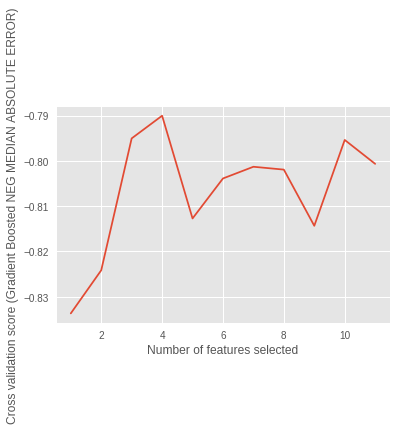

In [82]:
%matplotlib inline
# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (Gradient Boosted NEG MEDIAN ABSOLUTE ERROR)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

In [83]:
plt.style.use('ggplot')

rfe_ft_imp_df = pd.DataFrame({'feature_names':ml_df_features.columns, 'MAE':rfecv.grid_scores_})
rfe_ft_imp_df.sort_values(by='MAE', inplace=True, ascending=False )

topfeatures = rfe_ft_imp_df.head(25)

topfeatures

feature_names       MAE
3                 3 -0.790045
2                 2 -0.795053
9            BorZip -0.795392
10  COMMERCIALUNITS -0.800673
6                 6 -0.801312
7                 7 -0.801943
5                 5 -0.803896
4                 4 -0.812724
8                 8 -0.814348
1                 1 -0.824161
0                 0 -0.833681

Statistical Significance

In [64]:
#Adapted from 
#https://github.com/jakemdrew/DataMiningNotebooks/blob/master/06.%20Classification.ipynb

#Gradient Boosting

ML_std_scalr.fit(X_regr)


X_regr_scl = ML_std_scalr.transform(X_regr)

regr1 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)






cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err1 = cross_val_score(regr1 , X_regr_scl, y_regr, cv=cv, scoring = 'neg_median_absolute_error')

In [65]:
# Gradient Boosting with clustering


from sklearn.cluster import KMeans


X =  X_scl_df[['COMMERCIALUNITS', 'BorZip']]
y = y_scl
X1 = ml_df_enc_regr[['COMMERCIALUNITS', 'BorZip']]

cls = KMeans(n_clusters=9, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

y = y_scl
X = X_scl_df[['COMMERCIALUNITS', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))





regr2 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.001, loss='lad', max_depth=3,
                          max_features='auto', max_leaf_nodes=25,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)



cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err2 = cross_val_score(regr2, X, y, cv=cv, scoring = 'neg_median_absolute_error')

In [66]:
# Gradient Boosting with clustering

from sklearn.cluster import KMeans

X =  X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
y = y_scl_impute
X1 = ml_df_enc_regr_impute[['LLANDSQUAREFEET', 'BorZip']]

cls = KMeans(n_clusters=19, init='k-means++',random_state=1)
cls.fit(X1)
newfeature = cls.labels_ # the labels from kmeans clustering

ml_df_features = pd.concat([X1, pd.get_dummies(newfeature)])


y = y_scl_impute
X = X_scl_df_impute[['LLANDSQUAREFEET', 'BorZip']]
X = np.column_stack((X,pd.get_dummies(newfeature)))





regr3 = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mae', init=None,
                          learning_rate=0.1, loss='ls', max_depth=10,
                          max_features='auto', max_leaf_nodes=40,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=10, min_samples_split=3,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=0, subsample=0.01, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)


cv = ShuffleSplit(n_splits=10, test_size=0.20, random_state=959)

reg_err3 = cross_val_score(regr3, X, y, cv=cv, scoring = 'neg_median_absolute_error')

h0: The Median Absolute Error of the Gradient Boosting Regressor equals the Median Absolute Error of the Gradient Boosting Regressor with reduced cluster featuers

ha: The mean Median Absolute Error of the models are different

Comparing GradientBoostingRegressor and GradientBoostingRegressor with reduced features from clustering, the 95% confidence interval [0.0202, 0.0707] shows that the interval doesn't includes zero, which implies that the two models are statistically different and we reject null hypothesis. There is evidence to suggest the Gradient Boosting Regressor with reduced features from clustering is statistically better at prediciting sale price. 

In [71]:
# wanting to check 3 models accross 10 folds, therefore t = 2.764 with alpha = 0.05/2 and degrees of freedom = 10 
# we reject h0 the models are statistically different, as zero is not in the interval, The LASSO model is the better 
#regressor model. 


t =  2.764 / np.sqrt(10)

e = abs(reg_err1) - abs(reg_err2)

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (abs(np.mean(reg_err1)), abs(np.mean(reg_err2)))

Range of: 0.02022943868289238 0.07073822067074652
0.8655268792809698 0.8200430496041504


In [72]:
t =  2.764 / np.sqrt(10)

e = abs(reg_err2) - abs(reg_err3) 

stdtot = np.std(e)

dbar = np.mean(e)
print ('Range of:', dbar-t*stdtot,dbar+t*stdtot )
print (abs(np.mean(reg_err2)), abs(np.mean(reg_err3)))

Range of: 0.6136985285461136 0.7051974864786317
0.8200430496041504 0.16059504209177772


h0: The Median Absolute Error of the Gradient Boosting Regressor with reduced cluster features is equal to the Median Absolute Error of the Gradient Boosting Regressor with imputed values 

ha: The mean Median Absolute Error of the models are different

Comparing GradientBoostingRegressor with 9 clusters and GradientBoostingRegressor with 19 clusters from the imputed data, the 95% confidence interval [0.6137, 0.70520] shows that the interval doesn't includes zero, which implies that the two models are statistically different and we reject null hypothesis. There is evidence to suggest the Gradient Boosting Regressor with 19 clusters from the imputed data is statistically better at prediciting the log of sale price. 